# Hospital Readmission within 6 months Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add the project root directory to Python path
sys.path.append(os.path.abspath(".."))

from src import process, data_visualisation
from src.process import process_data




# Import data

### Visualise some information about the data

In [3]:
print("Number of patients and features:", df.shape, '\n')
df.info()

Number of patients and features: (2008, 167) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Columns: 167 entries, Unnamed: 0 to ageCat
dtypes: float64(119), int64(33), object(15)
memory usage: 2.6+ MB


# Data Analysis

In [4]:
#Check for duplicates
if df['inpatient.number'].is_unique: 
    print("No duplicates")
else:
    print("There are duplicates")

No duplicates


In [5]:
# Remove unnecessary columns 
df.drop(labels='Unnamed: 0', axis=1, inplace=True) # remove the column Unnamed: 0
df.drop(labels='inpatient.number', axis=1, inplace=True) # remove the column containing the patient ID

### Check for class unbalance

re.admission.within.6.months
0    1235
1     773
dtype: int64


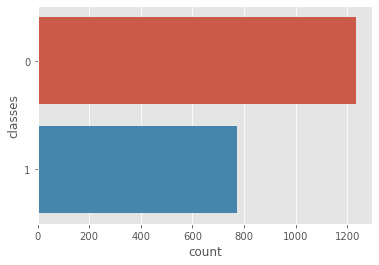

In [6]:
#Print class counts
print(df.groupby('re.admission.within.6.months').size())

%matplotlib inline
plt.style.use('ggplot')
#Visualize Class Counts
sns.countplot(y=df['re.admission.within.6.months'] ,data=df) 
plt.ylabel("classes")
plt.show()

### Dealing with dead patients in the dataset


In [7]:
#dead patients
dead_patients=df[df['death.within.6.months']==1]['re.admission.within.6.months'].value_counts()
dead_patients

0    57
Name: re.admission.within.6.months, dtype: int64

In [8]:
# Checking if dead patients were not readmitted within 6 months 
dead_patients = df['death.within.6.months'].value_counts()
print('Number of dead patients within 6 months:\n', dead_patients, '\n')
dead_read_patients = df[df['death.within.6.months']==1]['re.admission.within.6.months'].value_counts()
print("Number of dead patients readmitted within 6 months:\n", dead_read_patients)

Number of dead patients within 6 months:
 0    1951
1      57
Name: death.within.6.months, dtype: int64 

Number of dead patients readmitted within 6 months:
 0    57
Name: re.admission.within.6.months, dtype: int64


Since the dead patients constituted only the 3.09% of the population under study, they were removed from the dataset, also allowing to minimize the risk of introducing bias in the model. Following the same reasoning, the following features were dropped:
- death.within.6.months
- death.within.3.months
- death.within.28.days

In [9]:
df.drop(df[df['death.within.6.months']==1].index, inplace=True)

# The feature 'DestinationDischarge' still contained 5 patients classified as 'Died', that are dropped here.
df.drop(df[df['DestinationDischarge']== 'Died'].index, inplace=True)
df=df.drop(['death.within.28.days', 'death.within.3.months', 'death.within.6.months'],axis=1)

### Remove information about the future
With the aim of predicting an eventual readmission within 6 months, the variables containing information located in time after the first hospitalization were considered as referred to the future and were therefore removed. Such variables are listed hereafter:
- re.admission.within.3.months 
- re.admission.within.28.days 
- time.of.death..days.from.admission.
- re.admission.time..days.from.admission.
- return.to.emergency.department.within.6.months
- time.to.emergency.department.within.6.months

In [10]:
df=df.drop(['re.admission.within.3.months','re.admission.within.28.days','time.of.death..days.from.admission.','re.admission.time..days.from.admission.','return.to.emergency.department.within.6.months','time.to.emergency.department.within.6.months'], axis=1)

### Creation of a new feature

In [11]:
pd.set_option('display.max_rows', None)

high_nan = df.columns[df.isna().sum() > len(df)*0.40] #check over the columns with a percentage of nan value over 40%
percentage = df[high_nan.tolist()].isnull().sum() * 100 / len(df)

print("How many columns with %NaN > 40%? ", high_nan.size)
percentage.sort_values()

How many columns with %NaN > 40%?  40


mitral.valve.EMS                       50.462487
standard.bicarbonate                   51.027749
free.calcium                           51.027749
standard.residual.base                 51.027749
pH                                     51.027749
potassium.ion                          51.027749
chloride.ion                           51.027749
sodium.ion                             51.027749
glucose.blood.gas                      51.027749
partial.pressure.of.carbon.dioxide     51.027749
lactate                                51.027749
measured.bicarbonate                   51.027749
body.temperature.blood.gas             51.027749
oxygen.saturation                      51.027749
partial.oxygen.pressure                51.027749
anion.gap                              51.027749
measured.residual.base                 51.027749
total.carbon.dioxide                   51.027749
carboxyhemoglobin                      51.079137
reduced.hemoglobin                     51.079137
hematocrit.blood.gas

From this result, it is possible to see that some variables, such as 'chloride.ion','sodium.ion','glucose.blood.gas' and others, have exaclty the same amount of variables. 
The idea was that, probably, some people received a specific exam and some other people didn't. With the underlying hyphotesis that maybe only the people with a more serious grade had received the exam, we created a 
new binary variable called 'exam' equal to 1 for people who received the exam and 0 for the others. The features used for building this new variable will then be dropped in the section dedicated to dealing with NaN values.

In [12]:
pd.set_option('display.max_rows', 6)
df['exam'] = df['glucose.blood.gas'].isna()
df['exam'] = df['exam'].astype('object')

# K-fold Cross Validation
With the aim of reducing the luck component in the train-test split, 4-fold cross validation was employed to evaluate the performances of the models.

In [13]:
x = df.copy()
y = df['re.admission.within.6.months']

In [15]:
from sklearn.model_selection import StratifiedKFold

# We start by splitting the dataset in 4 folds, paying attention to keeping the same distribution of classes thanks
# to the StratifiedKFold method. 
kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42) 
result = []   

index = ['dataset']
i=0
for train_idx, val_idx in kfold.split(x, y):
    i=i+1
    train_fold = x.iloc[train_idx]
    val_fold = x.iloc[val_idx]
    result.append((train_fold, val_fold))

train_fold_1, val_fold_1 = result[0][0],result[0][1]
train_fold_2, val_fold_2 = result[1][0],result[1][1]
train_fold_3, val_fold_3 = result[2][0],result[2][1]
train_fold_4, val_fold_4 = result[3][0],result[3][1]

# Concatenate training and test folds
train_fold = [train_fold_1, train_fold_2, train_fold_3, train_fold_4] #train folds
val_fold = [val_fold_1, val_fold_2, val_fold_3, val_fold_4] #test folds

# Exploratory Data Analysis

At this point, an exploratory data analysis over each single training fold was performed. In this notebook we only report the results from the analysis on the training set resulting from the first iteration of k-fold cross validation procedure (i.e. from the set resulting from the merging of the first 3 created folds) and then generalized to the subsequent ones.
The analysis will be performed separately on numerical and categorical features. 

The conclusions which will be drawn from this phase will be due to observations made on all the iterations. 

In [16]:
df1=train_fold[0]

In [17]:
# Split into numerical and categorical variables only based on dtypes
df1_nume_init=df1.select_dtypes(include=['int64','float64']) # numerical features
print('Numerical variables:\n', df1_nume_init.columns)

df1_cate_init=df1.select_dtypes(include=['object']) # categorical features
print('Categorical variables:\n', df1_cate_init.columns, '\n')

Numerical variables:
 Index(['visit.times', 'body.temperature', 'pulse', 'respiration',
       'systolic.blood.pressure', 'diastolic.blood.pressure', 'map', 'weight',
       'height', 'BMI',
       ...
       'carboxyhemoglobin', 'body.temperature.blood.gas', 'oxygen.saturation',
       'partial.oxygen.pressure', 'oxyhemoglobin', 'anion.gap', 'free.calcium',
       'total.hemoglobin', 'GCS', 'dischargeDay'],
      dtype='object', length=141)
Categorical variables:
 Index(['DestinationDischarge', 'admission.ward', 'admission.way', 'occupation',
       'discharge.department', 'gender', 'type.of.heart.failure',
       'NYHA.cardiac.function.classification', 'Killip.grade',
       'type.II.respiratory.failure', 'consciousness', 'respiratory.support.',
       'oxygen.inhalation', 'outcome.during.hospitalization', 'ageCat',
       'exam'],
      dtype='object') 


## Categorical Features

In [18]:
pd.set_option('display.max_rows', None)
df1_cate_init.isna().sum()

DestinationDischarge                     0
admission.ward                           0
admission.way                            0
occupation                              18
discharge.department                     0
gender                                   0
type.of.heart.failure                    0
NYHA.cardiac.function.classification     0
Killip.grade                             0
type.II.respiratory.failure              0
consciousness                            0
respiratory.support.                     0
oxygen.inhalation                        0
outcome.during.hospitalization           0
ageCat                                   0
exam                                     0
dtype: int64

In [19]:
# With the aim of performing a better split among numerical and categorical variables, we visualize the values
# which can be assumed by each feature. 
print('DestinationDischarge:\n',df1['DestinationDischarge'].value_counts(),'\n')
print('admission.ward:\n',df1['admission.ward'].value_counts(),'\n')
print('admission.way:\n',df1['admission.way'].value_counts(),'\n')
print('occupation:\n',df1['occupation'].value_counts(),'\n')
print('discharge.department:\n',df1['discharge.department'].value_counts(),'\n')
print('gender:\n',df1['gender'].value_counts(),'\n')
print('type.of.heart.failure:\n',df1['type.of.heart.failure'].value_counts(),'\n')
print('NYHA.cardiac.function.classification:\n',df1['NYHA.cardiac.function.classification'].value_counts(),'\n')
print('Killip.grade:\n',df1['Killip.grade'].value_counts(),'\n')
print('type.II.respiratory.failure:\n',df1['type.II.respiratory.failure'].value_counts(),'\n')
print('consciousness:\n',df1['consciousness'].value_counts(),'\n')
print('respiratory.support.:\n',df1['respiratory.support.'].value_counts(),'\n')
print('oxygen.inhalation:\n',df1['oxygen.inhalation'].value_counts(),'\n')
print('outcome.during.hospitalization:\n',df1['outcome.during.hospitalization'].value_counts(),'\n')
print('ageCat:\n',df1['ageCat'].value_counts(),'\n')
print('exam:\n',df1['exam'].value_counts(),'\n')

DestinationDischarge:
 Home                  995
HealthcareFacility    323
Unknown               141
Name: DestinationDischarge, dtype: int64 

admission.ward:
 Cardiology     1111
GeneralWard     199
Others          138
ICU              11
Name: admission.ward, dtype: int64 

admission.way:
 NonEmergency    764
Emergency       695
Name: admission.way, dtype: int64 

occupation:
 UrbanResident    1216
farmer            136
Others             69
worker             14
Officer             6
Name: occupation, dtype: int64 

discharge.department:
 Cardiology     1241
GeneralWard     178
Others           39
ICU               1
Name: discharge.department, dtype: int64 

gender:
 Female    841
Male      618
Name: gender, dtype: int64 

type.of.heart.failure:
 Both     1063
Left      355
Right      41
Name: type.of.heart.failure, dtype: int64 

NYHA.cardiac.function.classification:
 III    763
IV     435
II     261
Name: NYHA.cardiac.function.classification, dtype: int64 

Killip.grade:
 II    

- The variable 'DestinationDischarge' contains a category 'Unknown': the idea is to set it to NaN and impute it,as will be shown later in the code. 
- The features 'NYHA.cardiac.function.classification', 'Killip.grade', 'ageCat' are categorical features but are characterized by an intrinsic order which must be kept. Therefore, they will be encoded using an Ordinal Encoder. 


In [20]:
pd.set_option('display.max_rows', 6)

/var/folders/kw/4lp9fgms3p1424bck2qhtdxr0000gn/T/ipykernel_52081/453375249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_cate_init['occupation'] = df1_cate_init['occupation'].astype('str') # fix for a variable which gave problems


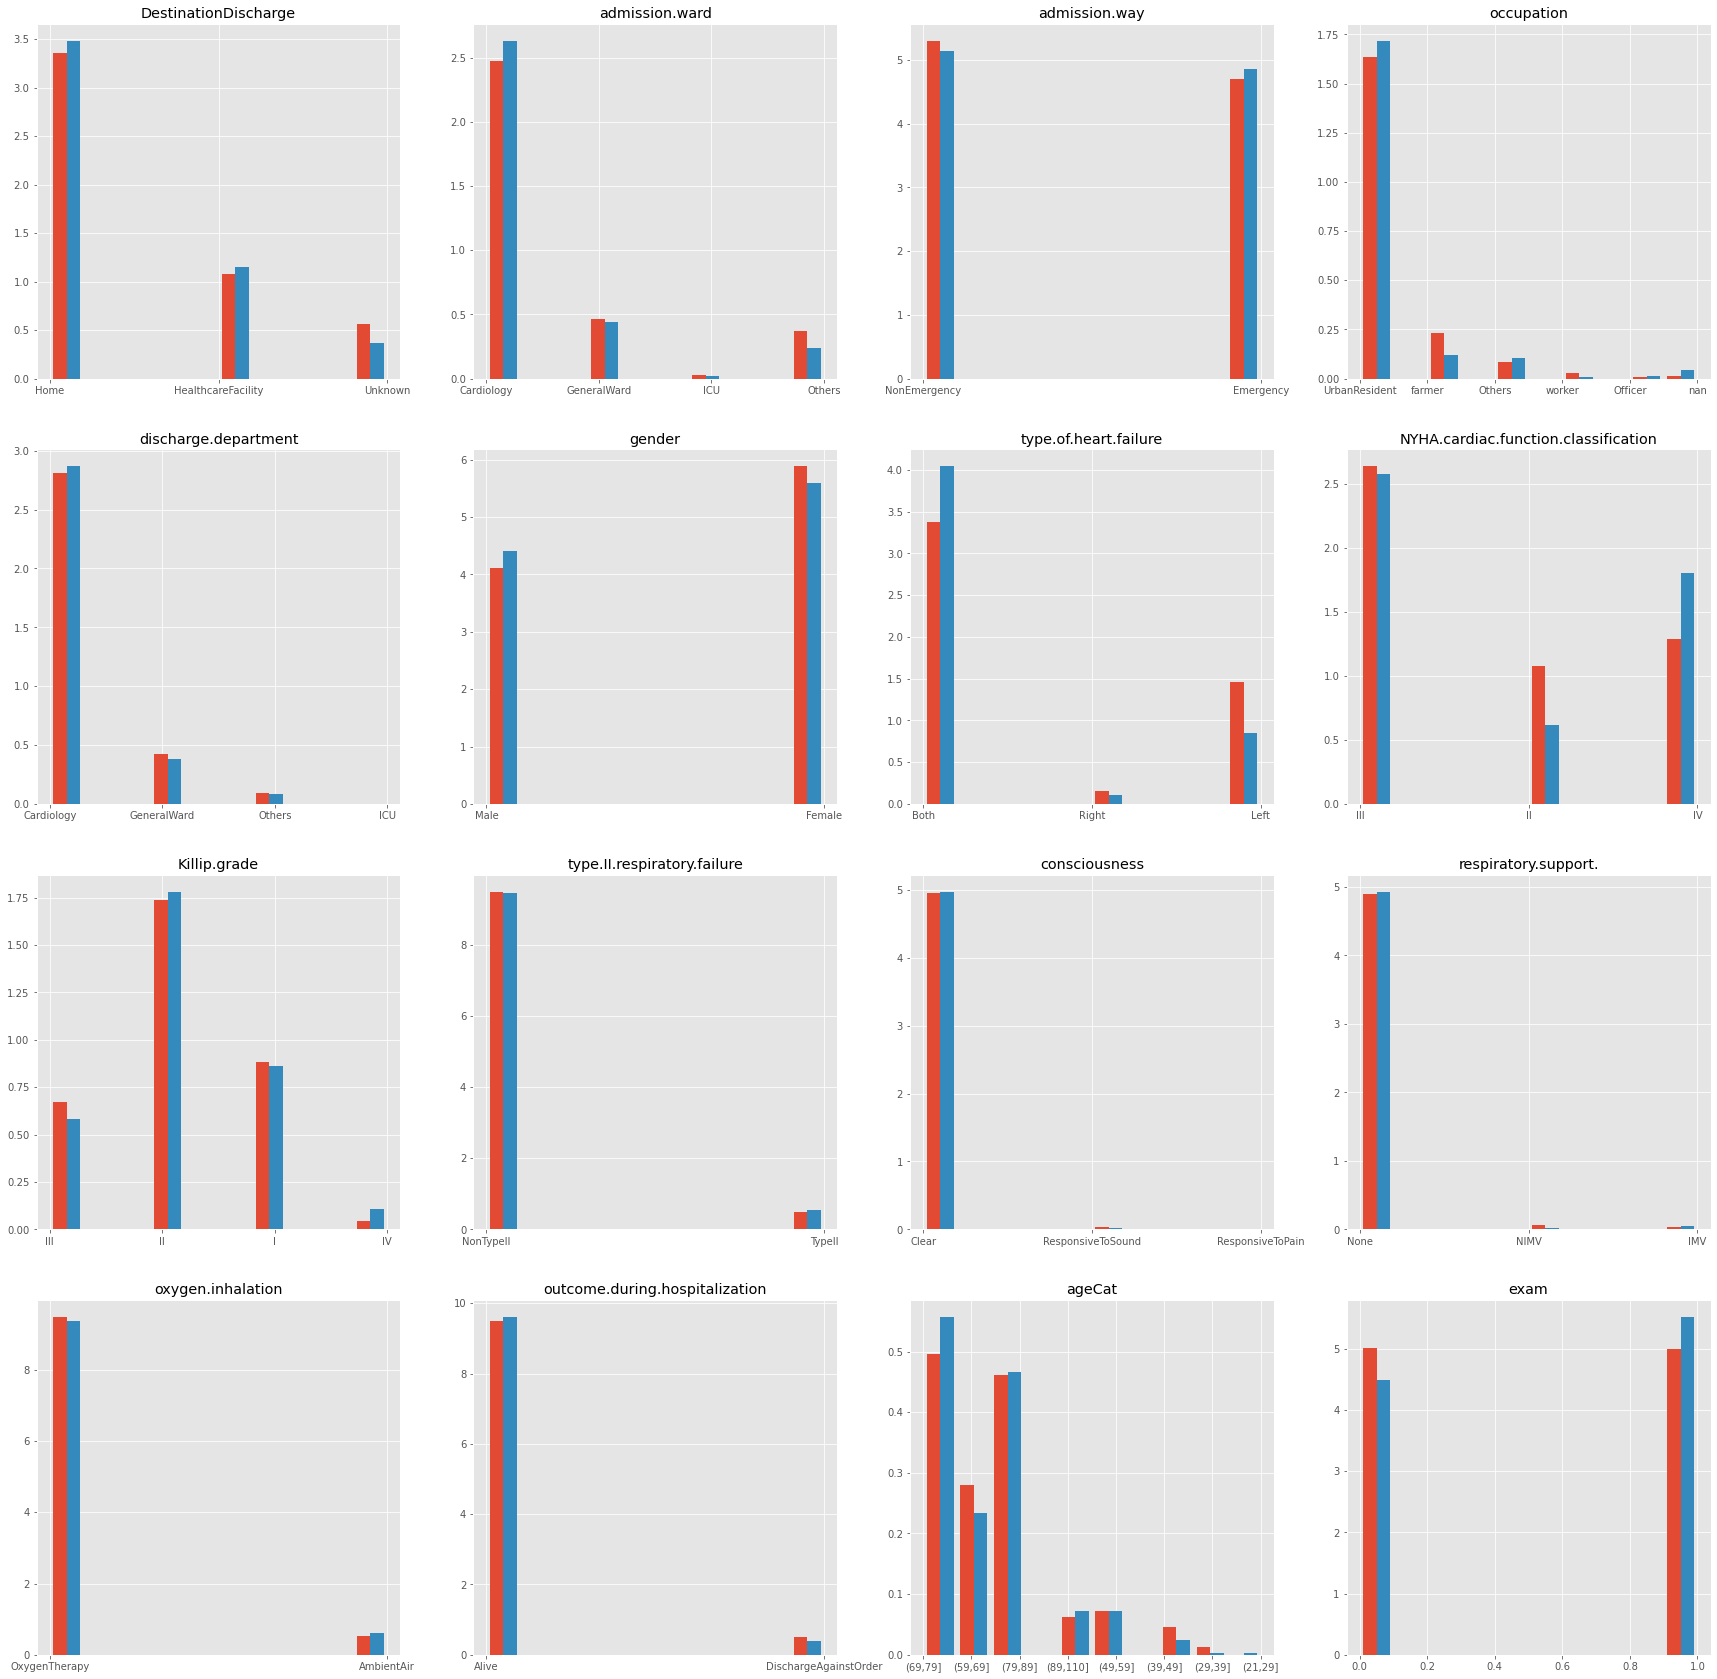

In [21]:
df1_cate_init['occupation'] = df1_cate_init['occupation'].astype('str') # fix for a variable which gave problems 
                                                                        #  in the plot

# Separately plot the distribution of categorical variables in the two target classes to investigate whether 
# each single variable is, alone, able to significatively differentiate whether patients will be readmitted 
# within 6 months:
df_0=df1_cate_init[df1['re.admission.within.6.months']==0] # records wih target==0
df_1=df1_cate_init[df1['re.admission.within.6.months']==1] # records wih target==1

fig, axes = plt.subplots(4,4,figsize=[30,30])
axes = axes.flatten()
i=0
for x in df1_cate_init.columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.title(x)
    i+=1         
plt.show()

From this representation, it is clear that some variables are not at all discriminative. After observing that this behavior was kept in each of the training folds generated at the different iterations of the K-fold cross validation, the following features were dropped:
- 'occupation',
- 'admission.ward', 
- 'admission.way', 
- 'discharge.department', 
- 'type.II.respiratory.failure', 
- 'consciousness',
- 'respiratory.support.',
- 'oxygen.inhalation', 
- 'outcome.during.hospitalization'

### Convert some 'int' or 'float' dtypes features into categorical
The initial split among categorical and numerical variables was made based on their type only. However, two cases in which this was not appropriate were identified:
* Binary variables.
* Variables which have few classes and are characterized by an intrinsic order.

#### Binary variables

In [22]:
# Binary variables as categorical
binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
                   'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease',
                   'diabetes','moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma',
                   'solid.tumor','liver.disease','AIDS','acute.renal.failure']

# Add binary variables to the categorical dataframe                   
df1_categorical= pd.concat([df1_cate_init,df1[binary_variables].astype('object')], axis = 1) 

# Drop binary variables from the numerical dataframe
df1_nume_init=df1_nume_init.drop(labels=binary_variables, axis=1, inplace=False)


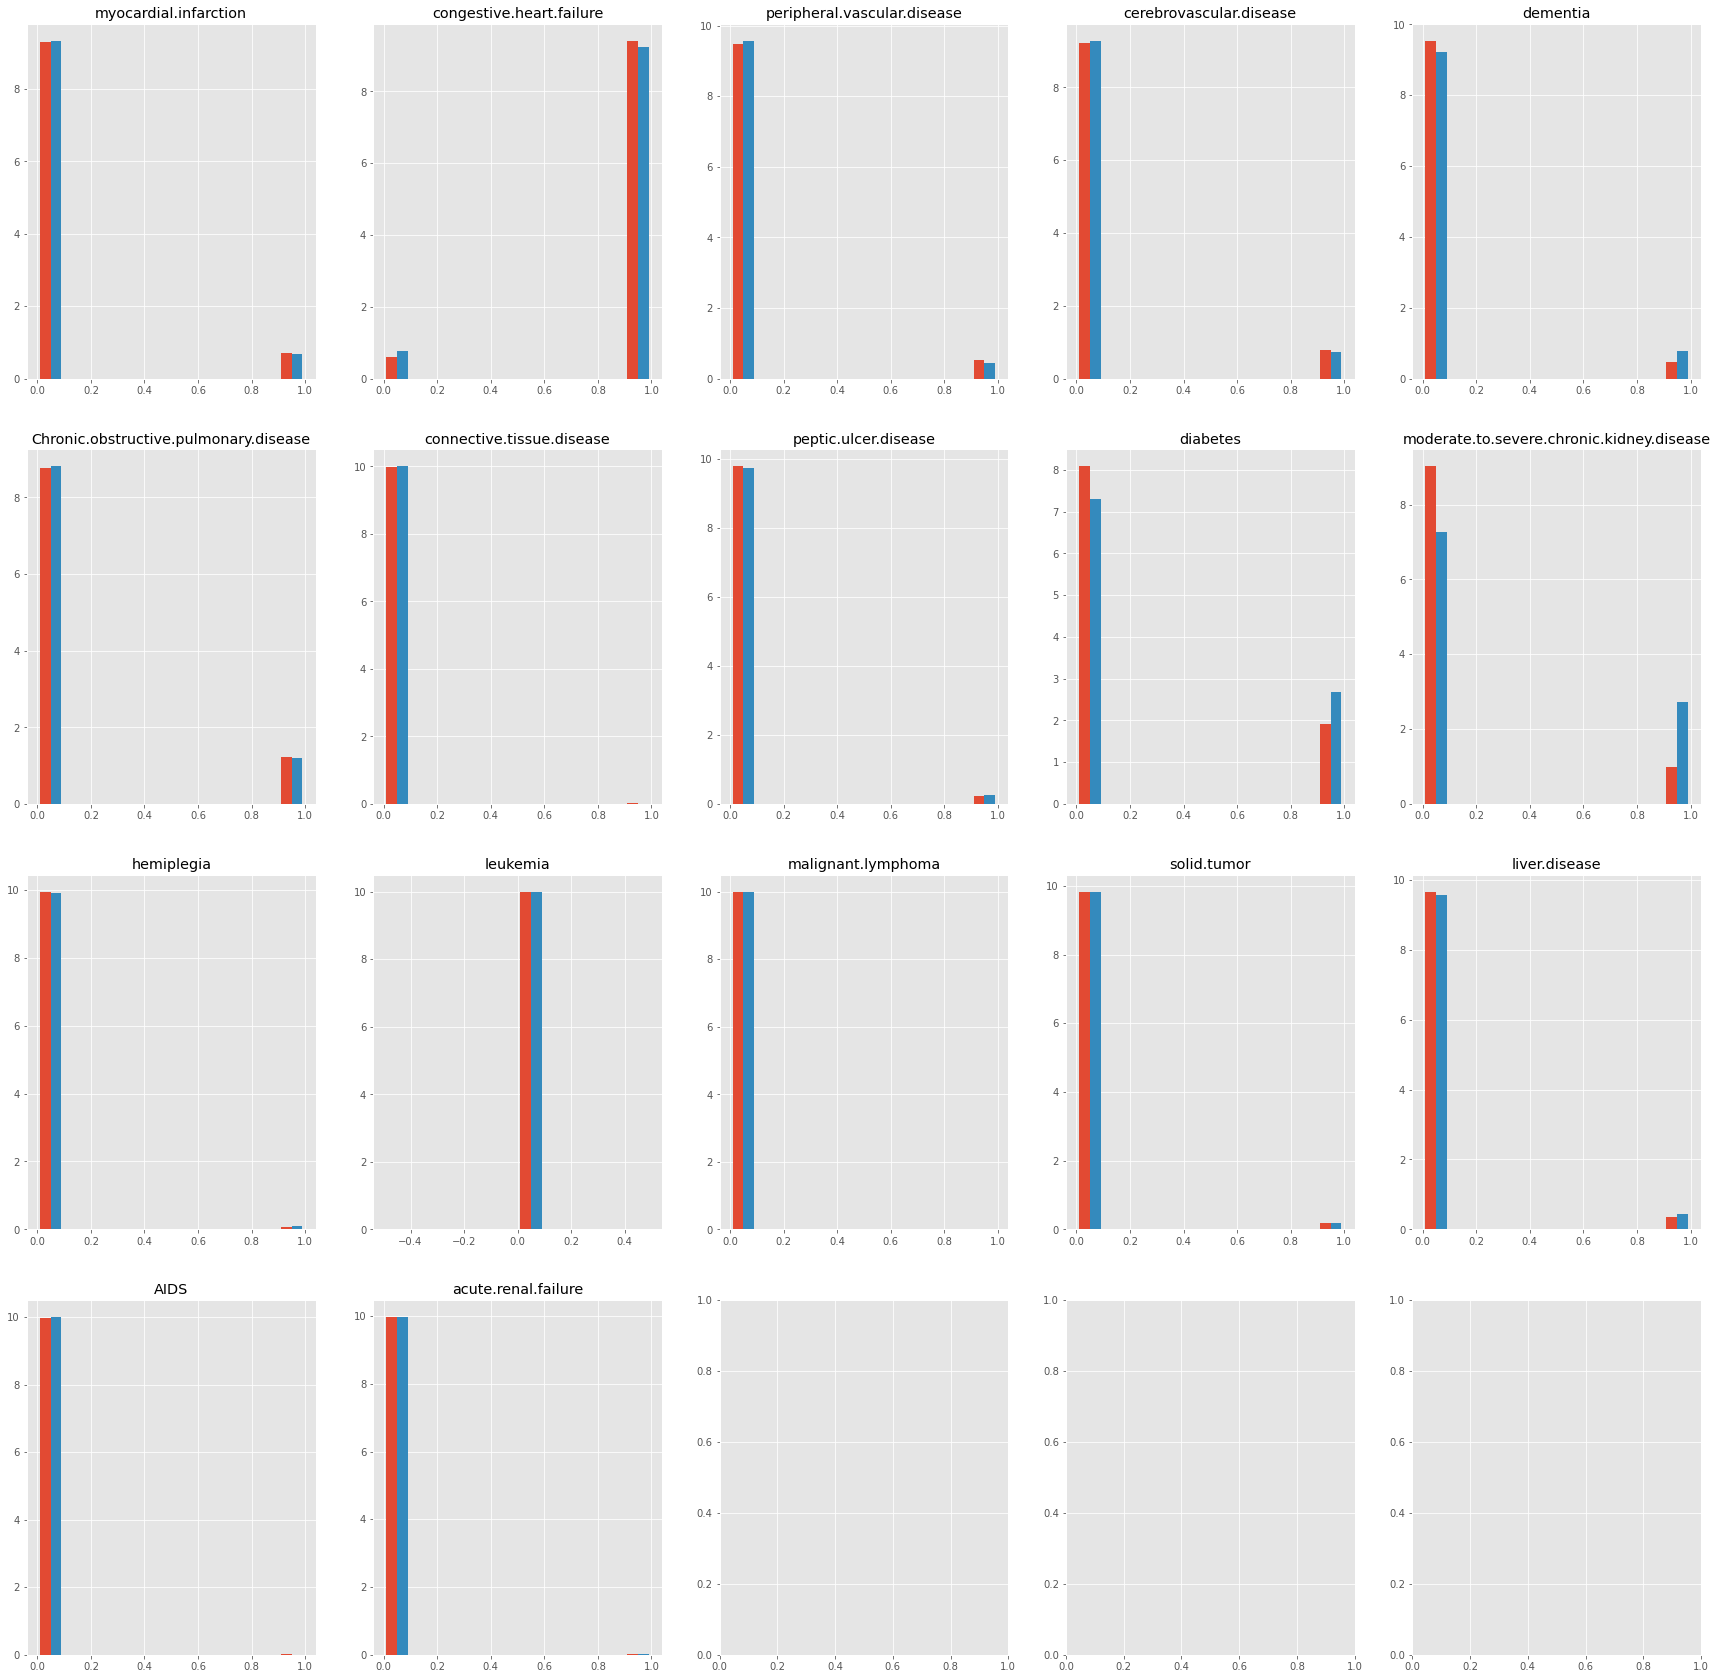

In [23]:
# As already done for the other categorical features, plot the distribution of binary variables in the two classes:
df_0=df1_categorical[df1['re.admission.within.6.months']==0] # records wih target==0
df_1=df1_categorical[df1['re.admission.within.6.months']==1] # records wih target==1

fig, axes = plt.subplots(4,5,figsize=[30,30])
axes = axes.flatten()
i=0
for x in df1_categorical[binary_variables].columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.title(x)
    i+=1         
plt.show()

From this representation, it is clear that some variables are not at all discriminative. After observing that this behavior was kept in each of the training folds generated at the different iterations of the K-fold cross validation, the following features were dropped:
- 'myocardial.infarction',
- 'congestive.heart.failure',
- 'peripheral.vascular.disease',
- 'cerebrovascular.disease',
- 'dementia', 
- 'Chronic.obstructive.pulmonary.disease',
- 'connective.tissue.disease',
- 'peptic.ulcer.disease',
- 'hemiplegia',
- 'leukemia',
- 'malignant.lymphoma',
- 'solid.tumor',
- 'liver.disease',
- 'AIDS',
- 'acute.renal.failure'

#### Variables which can assume few values and have an instric order

In [24]:
pd.set_option('display.max_rows', None)
print('visit times:\n',df1['visit.times'].value_counts(),'\n')
print('CCI score:\n',df1['CCI.score'].value_counts(),'\n')
print('eye.opening:\n',df1['eye.opening'].value_counts(),'\n')
print('verbal.response:\n',df1['verbal.response'].value_counts(),'\n')
print('movement:\n',df1['movement'].value_counts(),'\n')
print('GCS:\n',df1['GCS'].value_counts(),'\n')

visit times:
 1    1363
2      77
3      15
4       3
5       1
Name: visit.times, dtype: int64 

CCI score:
 1.0    574
2.0    504
3.0    270
4.0     59
0.0     38
5.0      9
6.0      1
Name: CCI.score, dtype: int64 

eye.opening:
 4    1442
3      13
1       2
2       2
Name: eye.opening, dtype: int64 

verbal.response:
 5    1439
3      10
2       7
1       2
4       1
Name: verbal.response, dtype: int64 

movement:
 6    1434
5      13
1       8
4       2
3       2
Name: movement, dtype: int64 

GCS:
 15    1431
11      11
10       5
14       4
7        3
12       2
3        2
6        1
Name: GCS, dtype: int64 


The variables 
* 'visit.times', 
* 'CCI.score',
* 'eye.opening',
* 'verbal.response',
* 'movement',
* 'GCS' 

can be converted into categorical variables, but they already have an ordinal encoded scale. 

In [25]:
# Define the features to move from numerical to categorical: 
ordinal_features=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']

# Add said variables to the categorical dataframe: 
df1_categorical= pd.concat([df1_categorical,df1[ordinal_features]], axis = 1) 

# Remove them from the numerical dataframe:
df1_nume_init=df1_nume_init.drop(labels=ordinal_features, axis=1, inplace=False)


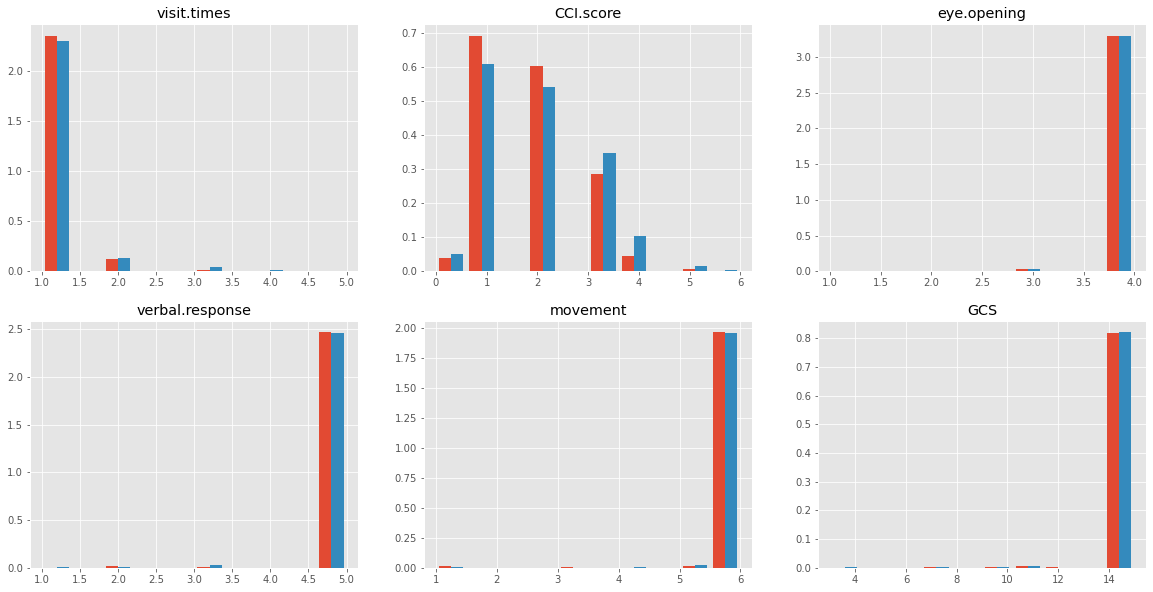

In [26]:
# As already done for the other categorical features, plot the distribution of 'ordinal variables' in the two classes:
df_0=df1_categorical[df1['re.admission.within.6.months']==0] # records wih target==0
df_1=df1_categorical[df1['re.admission.within.6.months']==1] # records wih target==1

fig, axes = plt.subplots(2,3,figsize=[20,10])
axes = axes.flatten()
i=0
for x in df1_categorical[ordinal_features].columns:
    plt.sca(axes[i]) # set the current Axes
    plt.hist([df_0[x],df_1[x]],density=True)
    plt.title(x)
    i+=1         
plt.show()

From this representation, it is clear that some variables are not at all discriminative. 
Moreover, the feature 'GCS' is obtained as the sum of 'eye.opening','verbal.response','movement': therefore, these three features were dropped, after verifying that this behavior was kept in each of the training folds generated at the different iterations of the K-fold cross validation. 

## Numerical Features

In [27]:
df1_nume_init.isna().sum()

body.temperature                                                    0
pulse                                                               0
respiration                                                         0
systolic.blood.pressure                                             0
diastolic.blood.pressure                                            0
map                                                                 0
weight                                                              0
height                                                              0
BMI                                                                 0
fio2                                                                0
LVEF                                                              988
left.ventricular.end.diastolic.diameter.LV                        503
mitral.valve.EMS                                                  740
mitral.valve.AMS                                                 1054
EA                  

array([[<AxesSubplot:title={'center':'body.temperature'}>,
        <AxesSubplot:title={'center':'pulse'}>,
        <AxesSubplot:title={'center':'respiration'}>,
        <AxesSubplot:title={'center':'systolic.blood.pressure'}>,
        <AxesSubplot:title={'center':'diastolic.blood.pressure'}>,
        <AxesSubplot:title={'center':'map'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'fio2'}>,
        <AxesSubplot:title={'center':'LVEF'}>,
        <AxesSubplot:title={'center':'left.ventricular.end.diastolic.diameter.LV'}>],
       [<AxesSubplot:title={'center':'mitral.valve.EMS'}>,
        <AxesSubplot:title={'center':'mitral.valve.AMS'}>,
        <AxesSubplot:title={'center':'EA'}>,
        <AxesSubplot:title={'center':'tricuspid.valve.return.velocity'}>,
        <AxesSubplot:title={'center':'tricuspid.valve.return.pressure'}>,
        <AxesSubplot:tit

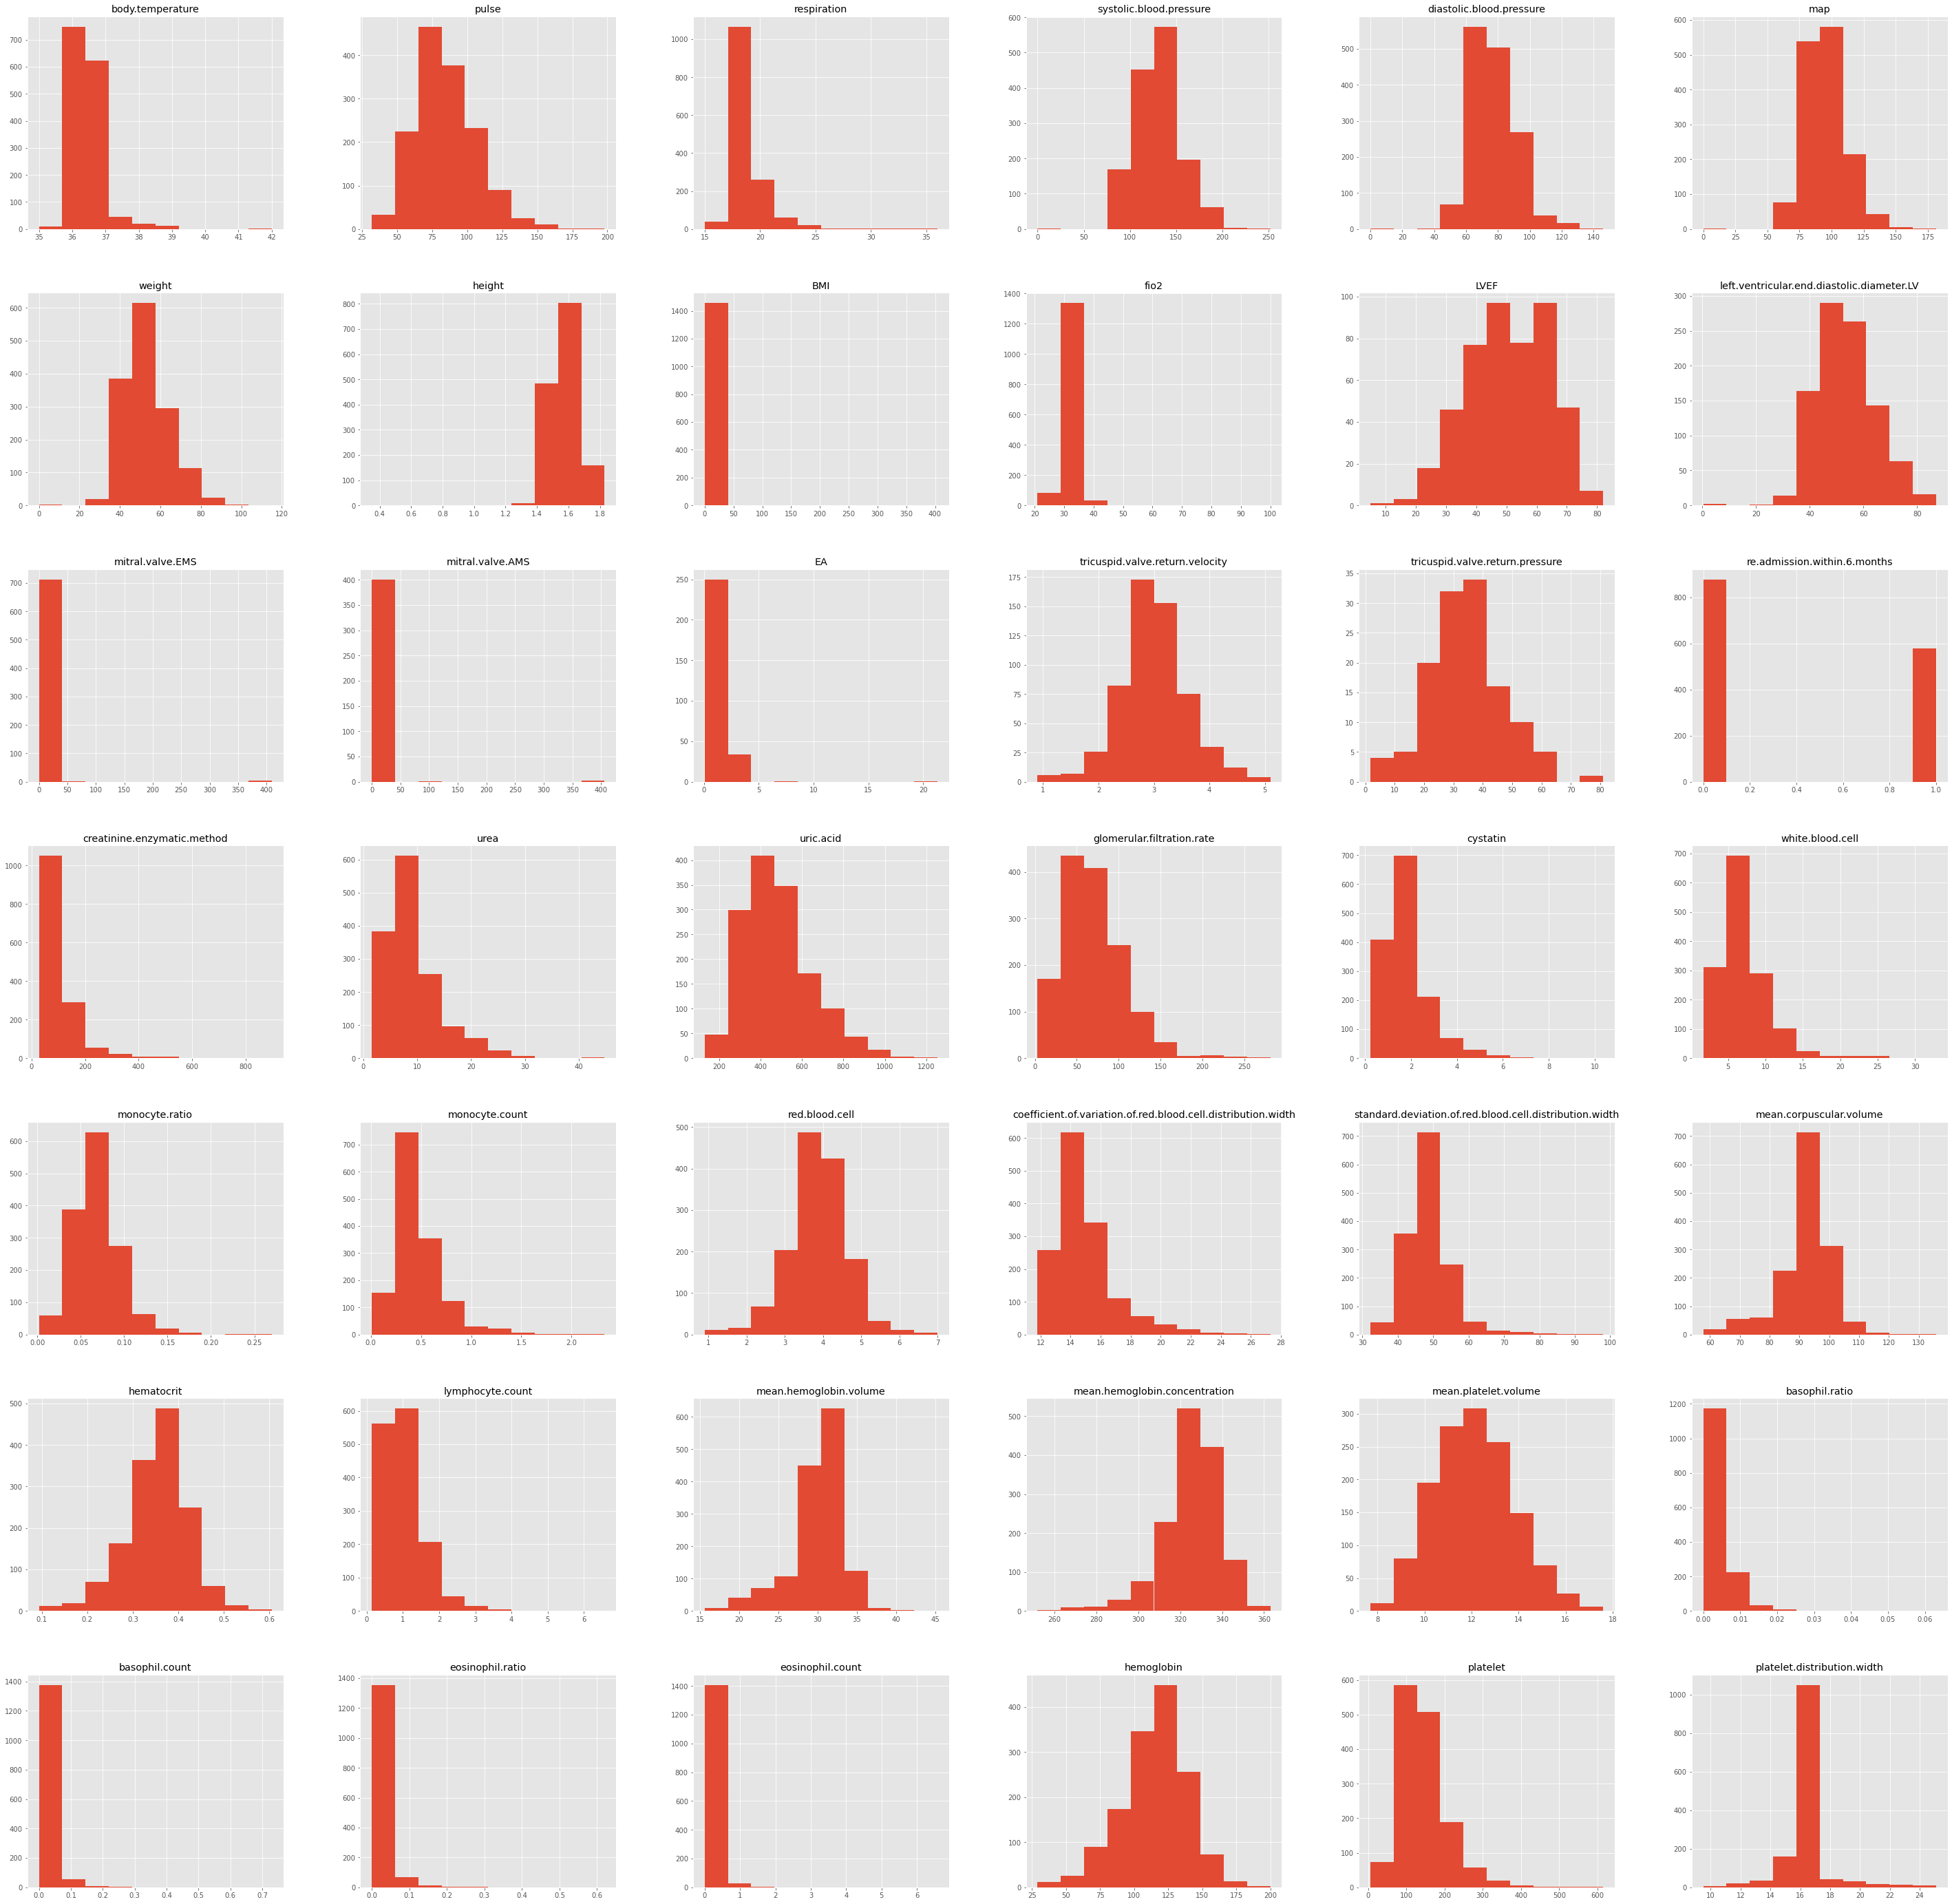

In [28]:
df1_nume_init[df1_nume_init.columns[0:42]].hist(figsize=(50,50))

array([[<AxesSubplot:title={'center':'neutrophil.ratio'}>,
        <AxesSubplot:title={'center':'neutrophil.count'}>,
        <AxesSubplot:title={'center':'D.dimer'}>,
        <AxesSubplot:title={'center':'international.normalized.ratio'}>,
        <AxesSubplot:title={'center':'activated.partial.thromboplastin.time'}>,
        <AxesSubplot:title={'center':'thrombin.time'}>],
       [<AxesSubplot:title={'center':'prothrombin.activity'}>,
        <AxesSubplot:title={'center':'prothrombin.time.ratio'}>,
        <AxesSubplot:title={'center':'fibrinogen'}>,
        <AxesSubplot:title={'center':'high.sensitivity.troponin'}>,
        <AxesSubplot:title={'center':'myoglobin'}>,
        <AxesSubplot:title={'center':'carbon.dioxide.binding.capacity'}>],
       [<AxesSubplot:title={'center':'calcium'}>,
        <AxesSubplot:title={'center':'potassium'}>,
        <AxesSubplot:title={'center':'chloride'}>,
        <AxesSubplot:title={'center':'sodium'}>,
        <AxesSubplot:title={'center':'Inorga

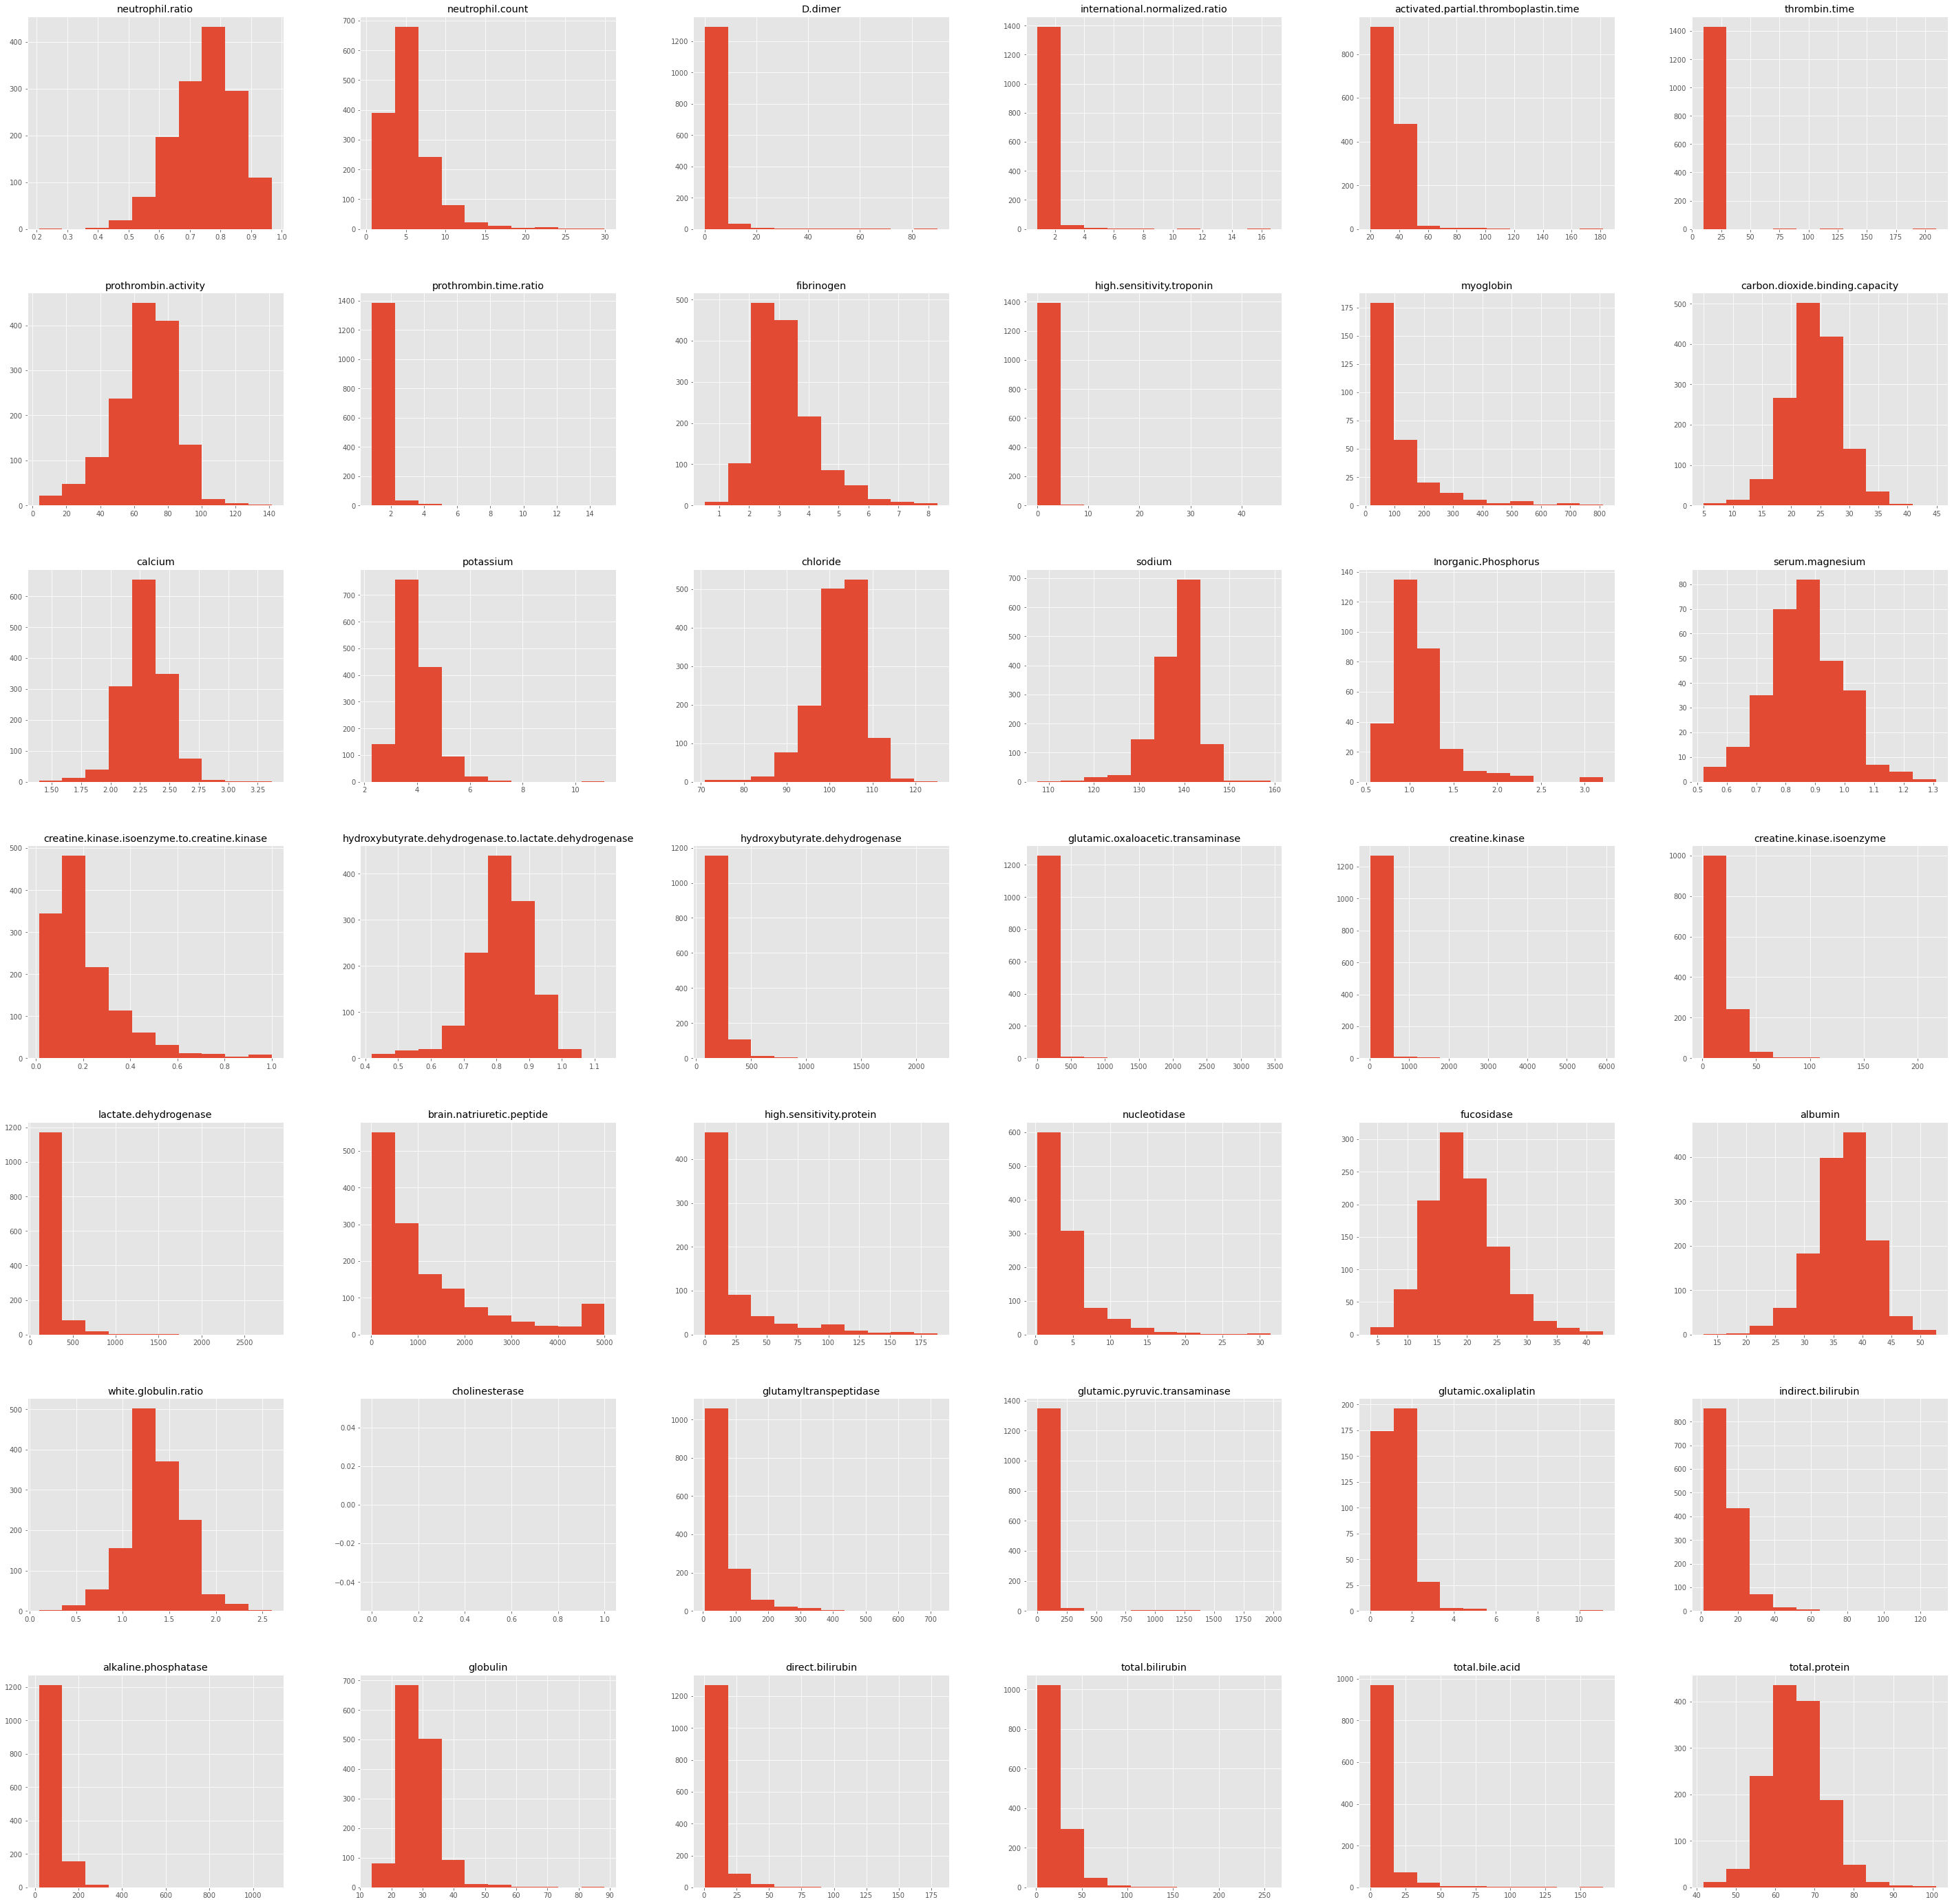

In [29]:
df1_nume_init[df1_nume_init.columns[43:85]].hist(figsize=(50,50))

The attribute 'cholinesterase' is made of NaN values only. Thus, we will remove the feature in the section of dealing with NaN.

array([[<AxesSubplot:title={'center':'cholesterol'}>,
        <AxesSubplot:title={'center':'low.density.lipoprotein.cholesterol'}>,
        <AxesSubplot:title={'center':'triglyceride'}>,
        <AxesSubplot:title={'center':'high.density.lipoprotein.cholesterol'}>,
        <AxesSubplot:title={'center':'homocysteine'}>,
        <AxesSubplot:title={'center':'apolipoprotein.A'}>],
       [<AxesSubplot:title={'center':'apolipoprotein.B'}>,
        <AxesSubplot:title={'center':'lipoprotein'}>,
        <AxesSubplot:title={'center':'pH'}>,
        <AxesSubplot:title={'center':'standard.residual.base'}>,
        <AxesSubplot:title={'center':'standard.bicarbonate'}>,
        <AxesSubplot:title={'center':'partial.pressure.of.carbon.dioxide'}>],
       [<AxesSubplot:title={'center':'total.carbon.dioxide'}>,
        <AxesSubplot:title={'center':'methemoglobin'}>,
        <AxesSubplot:title={'center':'hematocrit.blood.gas'}>,
        <AxesSubplot:title={'center':'reduced.hemoglobin'}>,
        <Axe

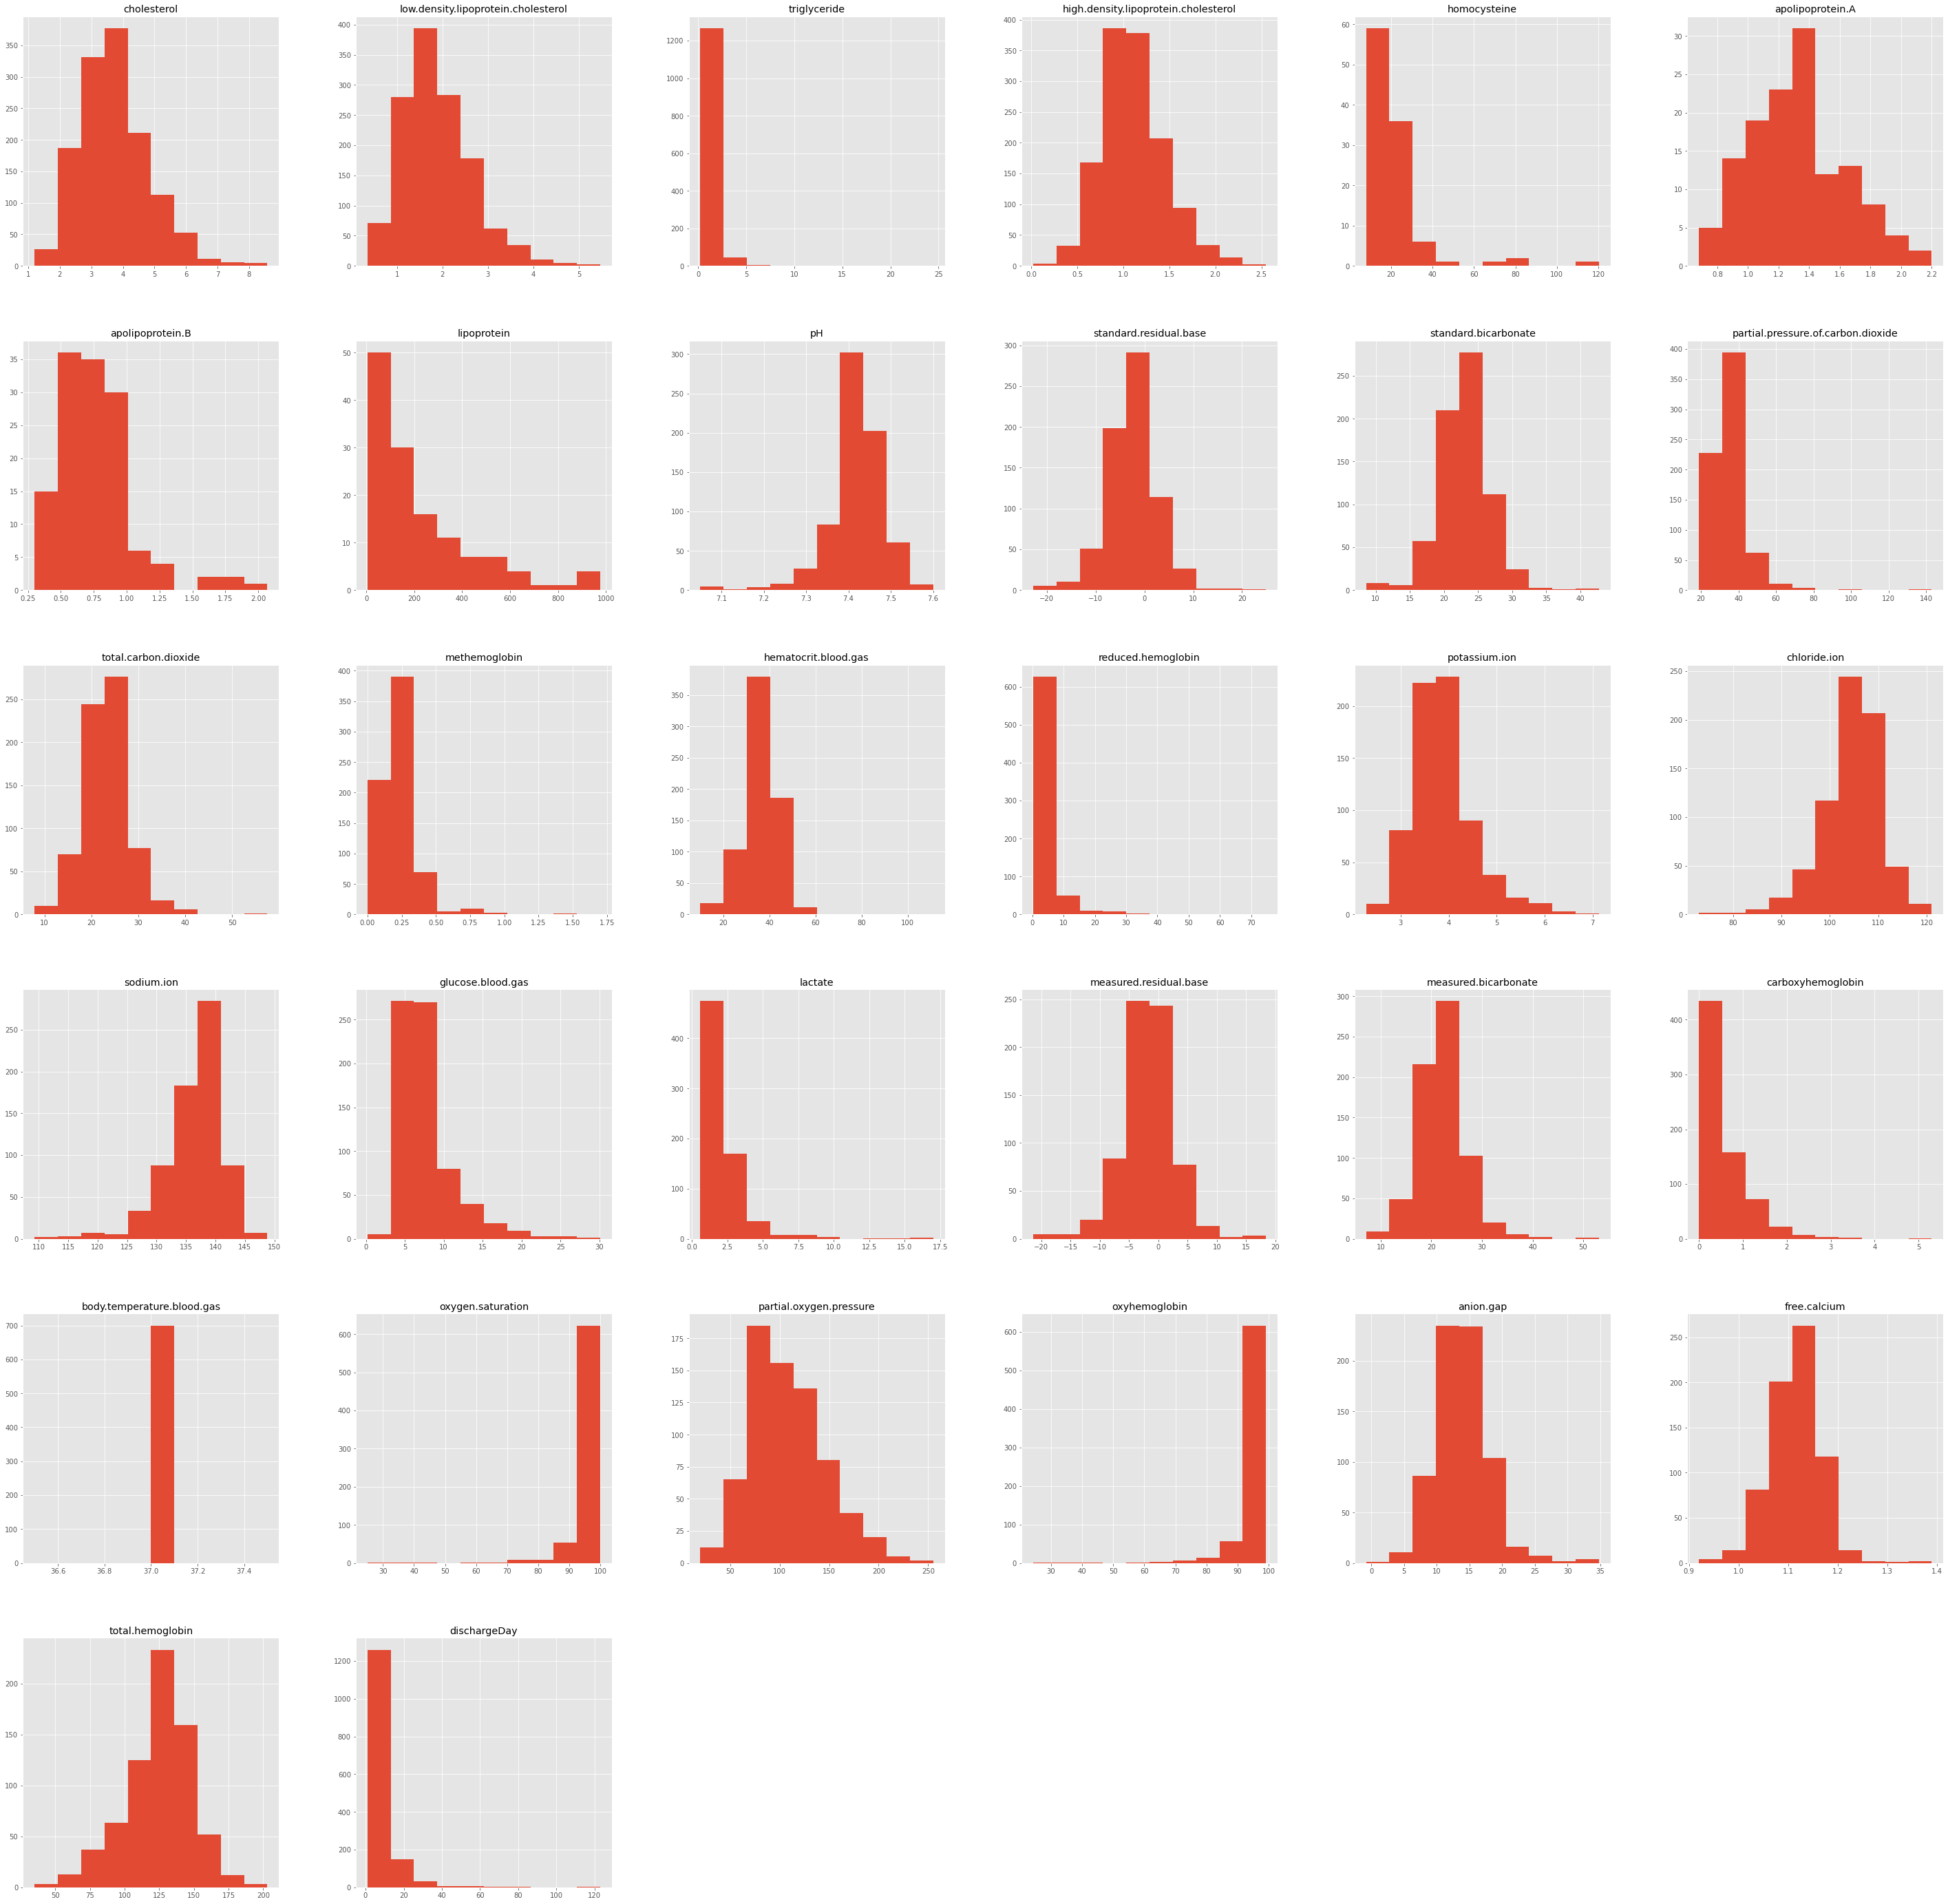

In [30]:
df1_nume_init[df1_nume_init.columns[86:124]].hist(figsize=(50,50))

From these histograms, it is possible to see that some features, such as 'body.temperature.blood.gas', are constant. Therefore, in the Feature Selection section, a step to remove low variance features will be performed. 

Some variables' distribution is not clearly visible, probably because of incorrect bin size or the presence of outliers. Thus, we will now make a deeper exploration of some of these variables.

array([[<AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'mitral.valve.AMS'}>],
       [<AxesSubplot:title={'center':'mitral.valve.EMS'}>,
        <AxesSubplot:title={'center':'systolic.blood.pressure'}>],
       [<AxesSubplot:title={'center':'diastolic.blood.pressure'}>,
        <AxesSubplot:title={'center':'map'}>]], dtype=object)

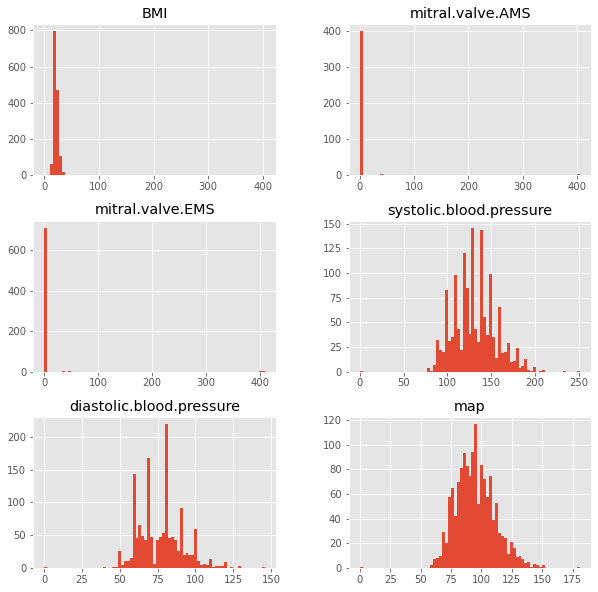

In [31]:
df1_nume_init[['BMI', 'mitral.valve.AMS','mitral.valve.EMS', 'systolic.blood.pressure', 'diastolic.blood.pressure', 'map']].hist(bins = 75, figsize = (10, 10))

array([[<AxesSubplot:title={'center':'tricuspid.valve.return.pressure'}>,
        <AxesSubplot:title={'center':'Inorganic.Phosphorus'}>,
        <AxesSubplot:title={'center':'myoglobin'}>],
       [<AxesSubplot:title={'center':'homocysteine'}>,
        <AxesSubplot:title={'center':'total.bile.acid'}>,
        <AxesSubplot:title={'center':'reduced.hemoglobin'}>],
       [<AxesSubplot:title={'center':'oxyhemoglobin'}>,
        <AxesSubplot:title={'center':'oxygen.saturation'}>,
        <AxesSubplot:title={'center':'lactate'}>],
       [<AxesSubplot:title={'center':'glucose.blood.gas'}>,
        <AxesSubplot:title={'center':'standard.deviation.of.red.blood.cell.distribution.width'}>,
        <AxesSubplot:>]], dtype=object)

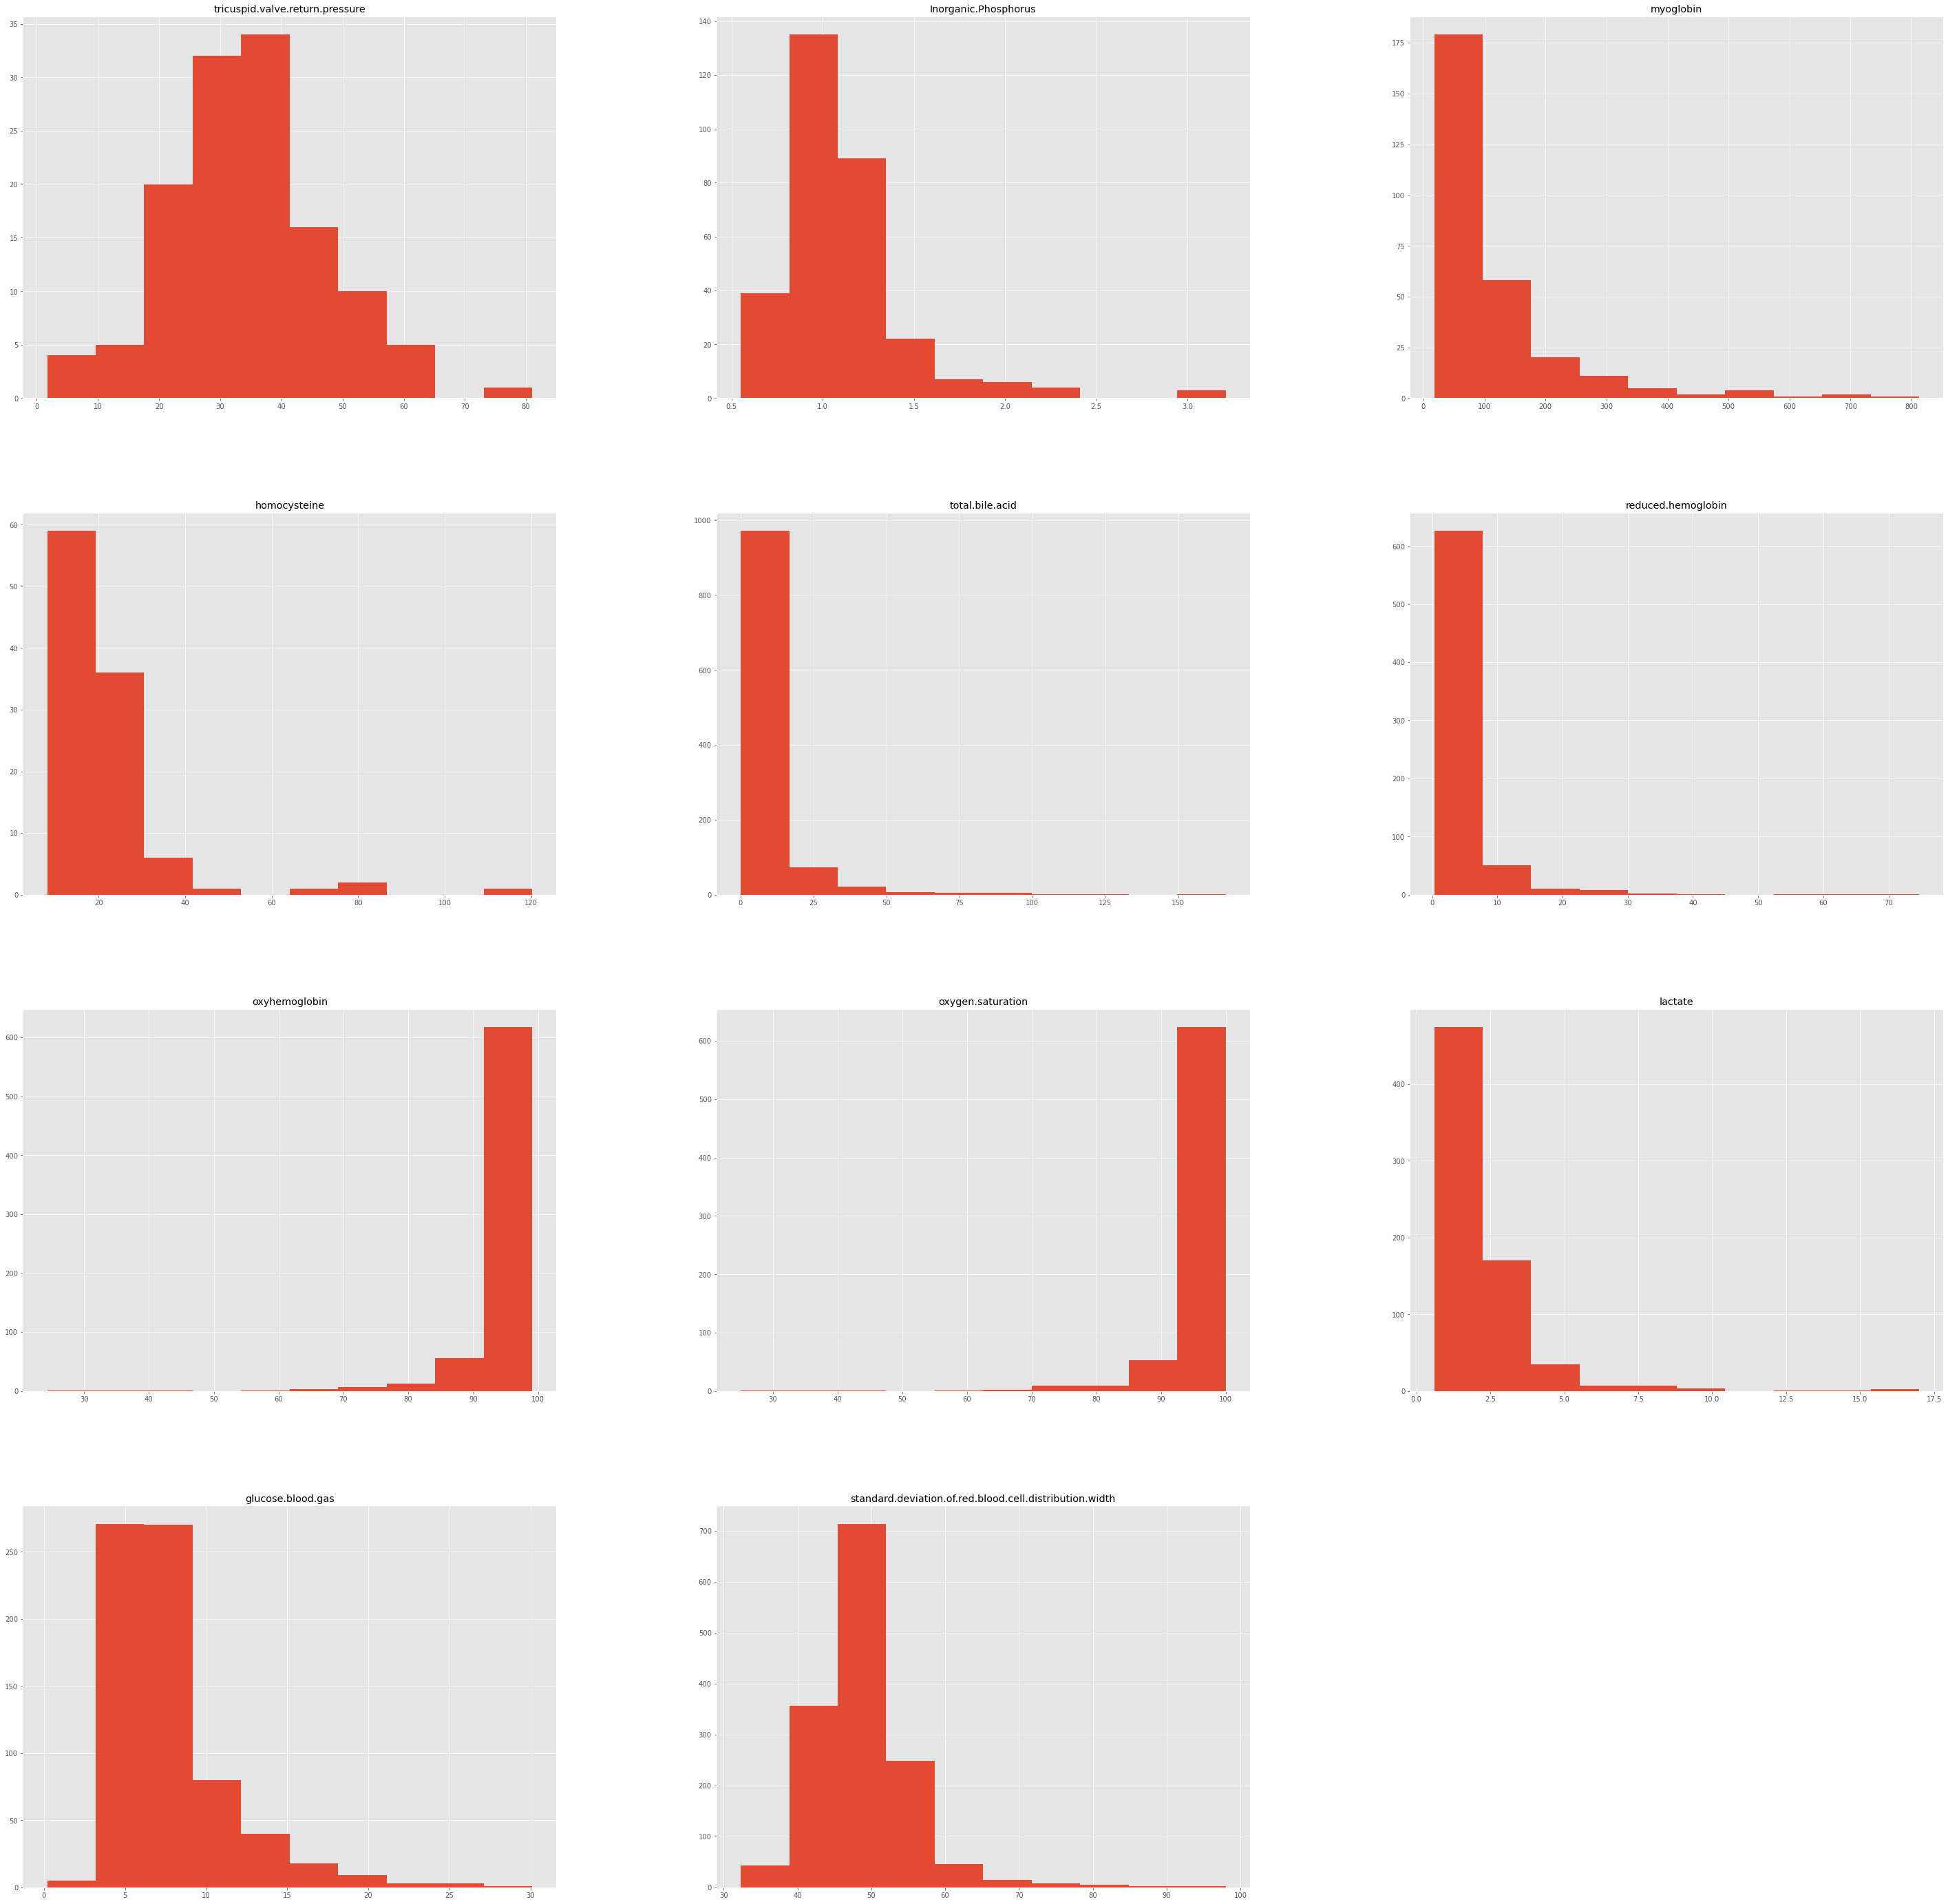

In [32]:
df1_nume_init[['tricuspid.valve.return.pressure', 'Inorganic.Phosphorus', 'myoglobin', 'homocysteine', 'total.bile.acid', 'reduced.hemoglobin', 'oxyhemoglobin', 'oxygen.saturation', 'lactate', 'glucose.blood.gas', 'standard.deviation.of.red.blood.cell.distribution.width' ]].hist(figsize=(50,50))

To investigate the presence of outliers, we can also plot the boxplots of these variables:

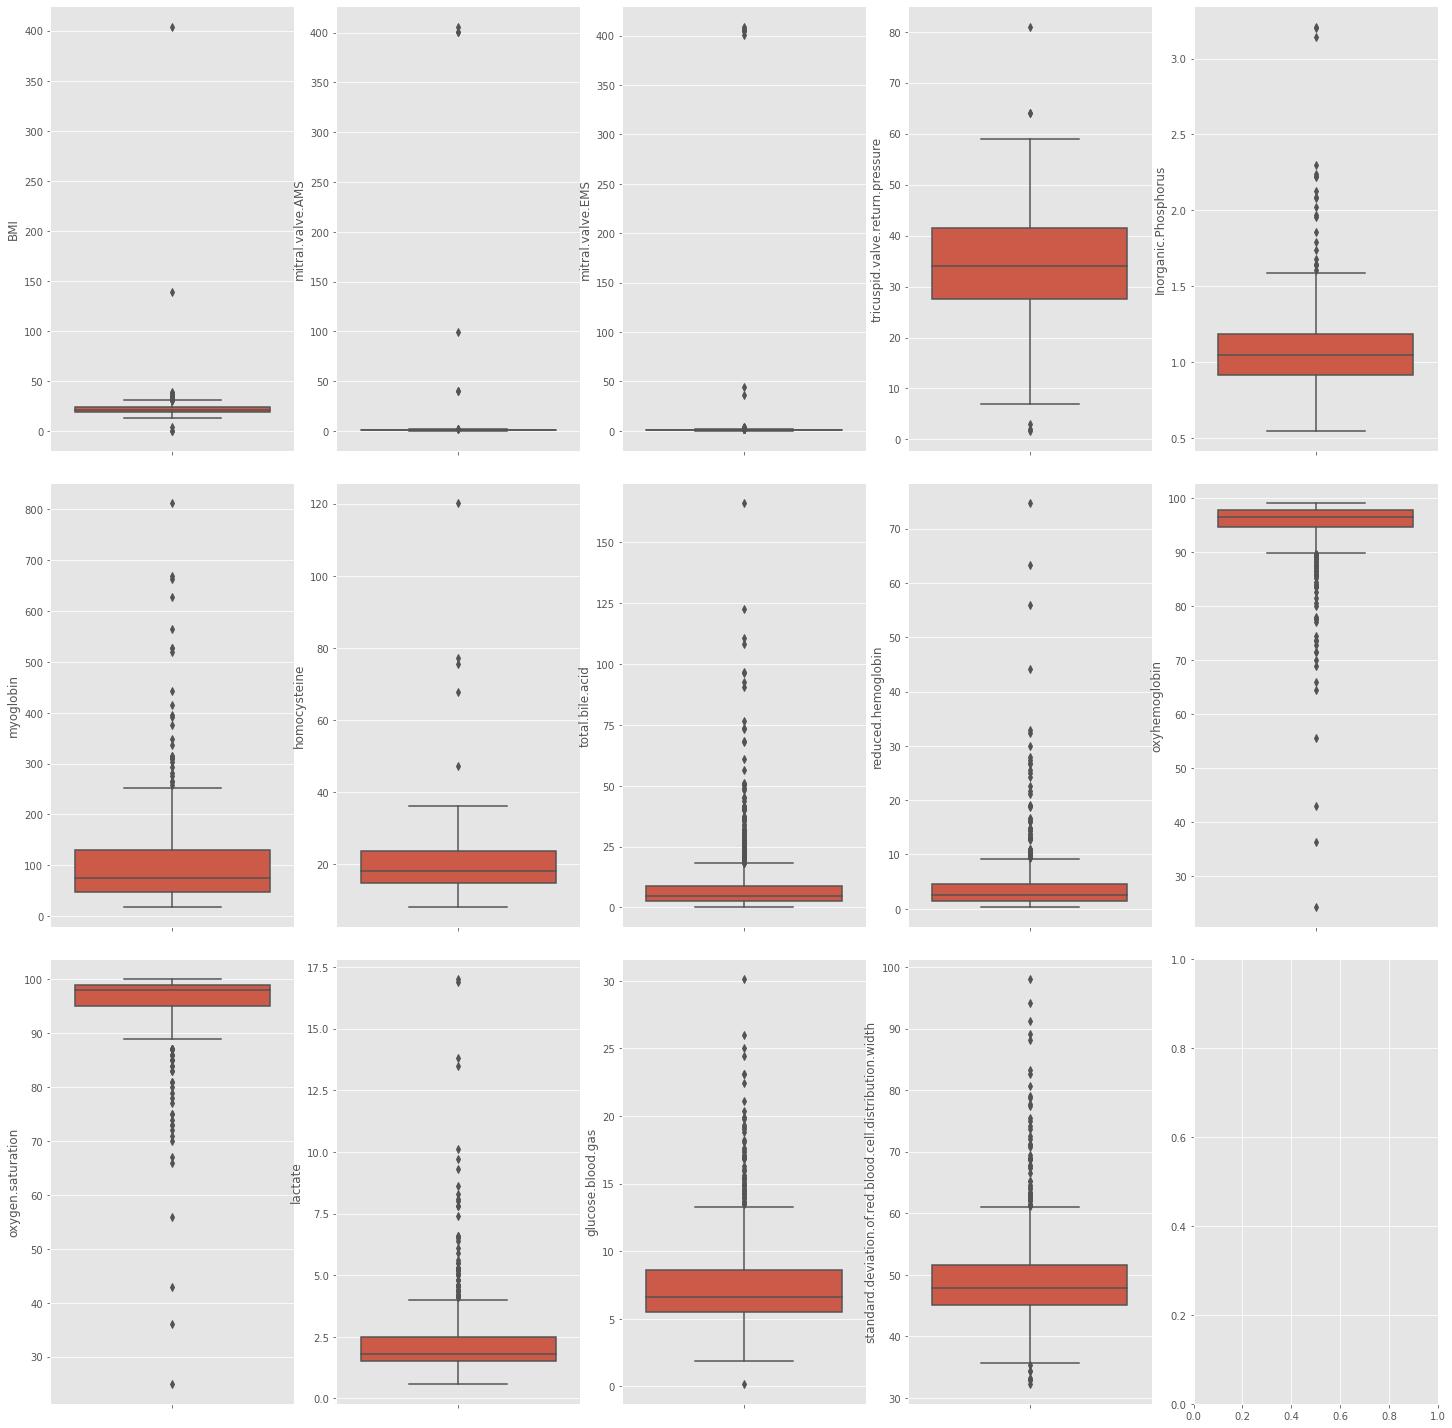

In [33]:
%matplotlib inline

fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(20,20))
fig.tight_layout()

columns = ['BMI', 'mitral.valve.AMS', 'mitral.valve.EMS', 'tricuspid.valve.return.pressure', 'Inorganic.Phosphorus', 'myoglobin', 'homocysteine', 'total.bile.acid', 'reduced.hemoglobin', 'oxyhemoglobin', 'oxygen.saturation', 'lactate', 'glucose.blood.gas', 'standard.deviation.of.red.blood.cell.distribution.width']
for i, col in enumerate(columns):
    sns.boxplot(y = col,data=df1_nume_init, orient='v', ax=axes[int(i/5),i%5])


## Dealing with Abnormalities

### Numerical Features

#### Outliers analysis

In [34]:
def plot_outliersAnalysis(abs_zscores):
  # number of outliers per subject 
  bool_zscores = (abs_zscores > 3).sum(axis=1)
  bool_zscores.hist()
  plt.title("Number of outliers per subject")
  plt.show()

  # number of outliers per feature 
  bool_zscores = (abs_zscores > 3).sum(axis=0)
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  feature_list_new = []
  bool_zscores_new = []
  for i in range(0, len(bool_zscores)):
    if bool_zscores[i] > 0:
        bool_zscores_new.append(bool_zscores[i])
        feature_list_new.append(feature_list[i])

            
  ax.bar(feature_list_new,bool_zscores_new)
  plt.title("Number of outliers per feature")
  plt.xticks(np.arange(len(feature_list_new)), feature_list_new,rotation=90)
  plt.show()
  return feature_list_new

Train subjects before outlier removal: (1459, 118)


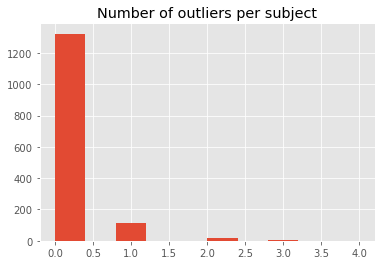

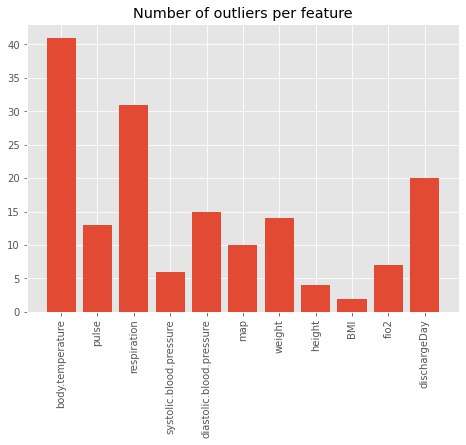

['body.temperature',
 'pulse',
 'respiration',
 'systolic.blood.pressure',
 'diastolic.blood.pressure',
 'map',
 'weight',
 'height',
 'BMI',
 'fio2',
 'dischargeDay']

In [35]:
from scipy.stats import zscore
train_labels = train_fold[0]['re.admission.within.6.months']
train_features = df1_nume_init

# 1. Perform z-scoring 
feature_list = df1_nume_init.columns.tolist()
print('Train subjects before outlier removal: ' + str(train_features.shape))

# apply zscore
zscore_features = df1_nume_init.apply(zscore, axis=0)
abs_zscores = abs(zscore_features)

plot_outliersAnalysis(abs_zscores)

Clealy, not all these values are really outliers: indeed, dealing with pathological conditions, many of these values are due to pathology itself. 
In particular, analyzing each of these features, only the following cases were found to be outliers, probably due to wrong entries:
-  'systolic.blood.pressure', 'diastolic.blood.pressure', 'map' = 0 values. 
- 'weight' = 0, 
- 'height' = 0.35cm
- 'BMI' = 404 


These were converted in NaN values. To do this, we define a class which we will then be able to use in the final Pipeline: this class will convert these specific conditions into NaN and will, in the end, drop the features characterized by a percentage of NaN values > 40%.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

class Outlier_to_Nan(BaseEstimator, TransformerMixin):
    def __init__(self, move_outliers=True): # no *args or **kargs
        self.move_outliers = move_outliers    
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        # Replace the conditions mentioned above with nan:
        X['systolic.blood.pressure'] = X['systolic.blood.pressure'].replace(0,np.nan)
        X['diastolic.blood.pressure'] = X['diastolic.blood.pressure'].replace(0,np.nan)
        X['map'] = X['map'].replace(0,np.nan)

        mask1 = X.height <1 
        column_name_1 = 'height'
        X.loc[mask1, column_name_1] = np.nan

        mask2 = X.weight < 10
        column_name_2 = 'weight'
        X.loc[mask2, column_name_2] = np.nan

        mask3 = X.BMI > 100 
        column_name_3 = 'BMI'
        X.loc[mask3, column_name_3] = np.nan

        mask4 = X.BMI < 4 
        column_name_4 = 'BMI'
        X.loc[mask4, column_name_4] = np.nan
        
        # Remove features with a percentage of nan > 40%:
        Feat_nan = X.columns[X.isna().sum()/len(X) > 0.40]
        X = X.drop(Feat_nan, axis=1)

        return X

#### NaN values analysis

As already said, features with a percentage of nan > 40% were simply removed from the dataset, since the imputation would have been biased and deleting the rows would have reduced the sample size too much. 

For the remaining variables, different possibilities were investigated, namely:
- Simple Imputation with mean
- Simple Imputation with median
- Iterative Imputation (MICE) considering a different number of nearest features (10,12,15). 

The following lines of code will show this analysis, which follows these steps:
1) Split the training fold into numerical and categorical variables, as shown above. 
2) Convert outliers to NaN and remove features with a percentage of nan > 40% using the class defined above. 
3) Apply different imputation methods and verify which brings to a better f1 score.

In [53]:
# Comparison of imputation methods
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# 1) Split the training fold into numerical and categorical variables
y1= train_fold[0]['re.admission.within.6.months']
x1=train_fold[0].drop(labels='re.admission.within.6.months', axis=1)

df1_numerical = x1.select_dtypes(include=['int64','float64'])
binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
        'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease','diabetes',
        'moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease',
        'AIDS','acute.renal.failure']
ordinal_variables=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']
df1_numerical=df1_numerical.drop(labels=binary_variables, axis=1)
df1_numerical=df1_numerical.drop(labels = ordinal_variables, axis=1)

# 2) Convert outliers to NaN and remove features with a percentage of nan > 40% 
pipe1 = Pipeline([
        ('outlier_to_Nan', Outlier_to_Nan()),
        ])
new_num = pipe1.fit_transform(df1_numerical)
num_attributes=new_num.columns
arr_min = new_num.min()
arr_max = new_num.max()

# 3) Apply different imputation methods and verify which brings to a better f1 score
N_SPLITS=3
br_estimator = RandomForestClassifier()

# Estimate the score after single imputation (mean and median strategies): 
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator)
    score_simple_imputer[strategy] = cross_val_score(
        estimator, new_num, y1, scoring="f1", cv=N_SPLITS
    )   

# Estimate the score after iterative imputation of the missing values with different numbers of nearest features (10,12,15)
score_iterative_imputer = pd.DataFrame()
sorted(sklearn.metrics.SCORERS.keys())
n_features = (10,12,15)
for nf in n_features:
    estimator = make_pipeline(
        IterativeImputer(
            missing_values=np.nan,
            random_state=0,
            sample_posterior=True,
            n_nearest_features = nf,
            min_value = arr_min,
            max_value =arr_max
        ),
        br_estimator,
    )
    score_iterative_imputer[nf] = cross_val_score(
        estimator, new_num, y1, scoring="f1", cv=N_SPLITS
    )

score_iter_imputer = pd.DataFrame(score_iterative_imputer)

scores = pd.concat(
    [score_simple_imputer, score_iter_imputer],
    keys=["SimpleImputer", "IterativeImputer"],
    axis=1)
scores

SimpleImputer           IterativeImputer                    
           mean    median               10        12        15
0      0.256410  0.274809         0.305344  0.247012  0.253846
1      0.266160  0.355072         0.304348  0.311111  0.294964
2      0.384342  0.352941         0.324324  0.322344  0.368231

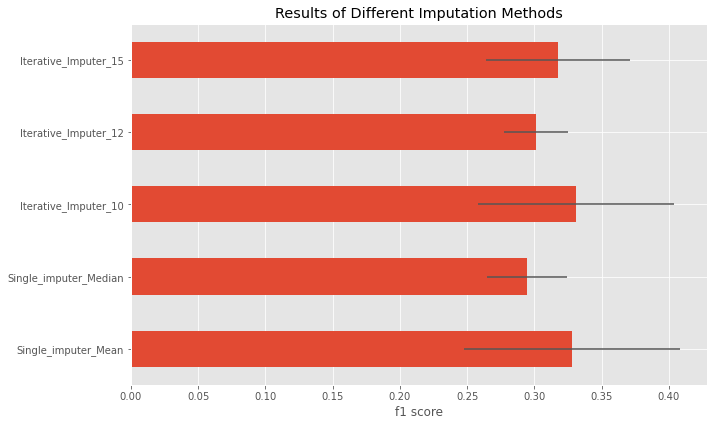

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
means, errors = scores.mean(), scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Results of Different Imputation Methods")
ax.set_xlabel("f1 score")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(["Single_imputer_Mean", "Single_imputer_Median", "Iterative_Imputer_10","Iterative_Imputer_12","Iterative_Imputer_15"])
plt.tight_layout(pad=1)
plt.show()

In [54]:
means, errors = scores.mean(), scores.std()
means

SimpleImputer     mean      0.302304
                  median    0.327608
IterativeImputer  10        0.311339
                  12        0.293489
                  15        0.305680
dtype: float64

In the end, the IterativeImputer with 10 nearest features method was chosen. 

### Categorical features
The imputation method chosen when dealing with NaN values in categorical features is a SimpleImputer with the mode. 

# Preprocessing and feature selection phase
After this data analysis step, we define a function, called 'processing', which will perform different tasks:

    1) Train-test folds selection: at each iteration, select 3 folds for training and one fold for testing. 

    2) Preprocessing, consisting of different steps for different features. 

For numerical features:

    a. convert outliers to nan and remove features with a percentage of nan > 40%
    b. MICE for imputing missing values
    c. standard scaling

For categorical features: 

    a. SimpleImputer ('most_frequent')
    b. encoding, which can be either OneHot, Ordinal, or nothing, as will be better explained below inside the function. 

    3) Feature Selection, which consists of three steps (two filter methods and one wrapper method):
    
    a. Remove low variance (constant) features 
    b. Remove features characterized by a correlation >0.85: among two correlated features, keep the one which has
     a lower mean correlation with all the other variables. 
    c. Sequential backward selection using a DecisionTreeClassifier

    4) SMOTE (optional): 
    the SMOTE algorithm was one of the investigated choices to deal with the problem of class imbalance. This algorithm, 
    slightly different from classical Oversampling technique, is a data augmentation technique which creates synthetic 
    instances belonging to the minority class as the result of a convex combination (i.e. a linear combination in which 
    all coefficients are non negative and sum up to 1) between an observation x, randomly selected from the class to 
    augment, and another one y, picked at random as well from the subset of k-nearest neighbors of x. 

    5) Adapt the test set


In [37]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import VarianceThreshold 
from itertools import compress
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [38]:
# This function receives as input, at each iteration:
# - the train (train_fold) and test (val_fold) folds obtained, at each iteration, as the concatenation of 
#    three folds for training and one fold for testing 
# - the fold number, meaning the current iteration (ranging from 0 to 3)
# - a boolean parameter to decide whether to perform SMOTE in order to balance the classes or not. 

def processing(train_fold, val_fold, fold_number, oversampling): 


# 1) Train-test folds selection

    X_train_fold=train_fold[fold_number] # train fold 
    X_train= X_train_fold.drop('re.admission.within.6.months', axis=1)
    y_train= X_train_fold['re.admission.within.6.months'].astype(int)
    
    X_val_fold=val_fold[fold_number] # test fold 
    X_test= X_val_fold.drop('re.admission.within.6.months',axis=1)
    y_test=X_val_fold['re.admission.within.6.months'].astype(int)

# 2) Scaling and feature selection 
    # Numerical features 
    # Select numerical variables based on their dtype:
    df_numerical = X_train.select_dtypes(include=['int64','float64']) 

    # Identify binary variables and variables which can assume few values and drop them from the numerical dataframe 
    # to include them in the categorical daraframe. 
    binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
        'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease','diabetes',
        'moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease',
        'AIDS','acute.renal.failure']
    ordinal_variables=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']
    df_numerical=df_numerical.drop(labels=binary_variables, axis=1)
    df_numerical=df_numerical.drop(labels = ordinal_variables, axis=1)
    
    # Categorical features
    # Select numerical variables based on their dtype:
    df_categorical = X_train.select_dtypes(include='object')

    # Include 'binary_variables' and 'ordinal_variables' in the categorical dataframe:
    df_categorical= pd.concat([df_categorical,X_train[binary_variables]], axis=1)
    df_categorical= pd.concat([df_categorical,X_train[ordinal_variables]], axis = 1)

    # The Exploratory Data Analysis step performed on the training set corresponding to each iteration of the K fold 
    # cross validaiton revealed some features which never appeared to be significative, based on the graphic representations 
    # seen above. Therefore, they were removed from the dataset:
    variables_to_drop=['eye.opening','verbal.response','movement','admission.ward', 'admission.way', 'discharge.department', 'type.II.respiratory.failure', 'consciousness','respiratory.support.','oxygen.inhalation', 'outcome.during.hospitalization','myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease','dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease','AIDS','acute.renal.failure']
    df_categorical = df_categorical.drop(labels=variables_to_drop, axis=1)

    # The variable 'DestinationDischarge' contained a class called 'Unknown', which we decided to convert to nan 
    # in order to perform an imputation. 
    df_categorical['DestinationDischarge'] = df_categorical['DestinationDischarge'].replace('Unknown',np.nan)
    
    # Define the Numerical Pipeline
    num_attributes=df_numerical.columns # Define numerical attributes
    
    # The following 7 lines of code were defined only to compute the new values of arr_min and arr_max, needed to 
    # bound the values imputed by MICE algorithm between the minimum and maximum they assumed in the original 
    # training set. This was necessary since without these parameters the MICE algorithm generated abnormal values
    # (e.g. negative heights). 
    pipe_to_help = Pipeline([
        ('outlier_to_Nan', Outlier_to_Nan()),
        ])
    new_num = pipe_to_help.fit_transform(df_numerical)
    num_attributes=new_num.columns # This is now changed because the class Outlier_to_NaN removes features with a high
                                   # percentage of nan (>40%): this toy pipeline was needed for this reason, meaning
                                   # to be able to obtain the new column names and the minimum and maximum values
                                   # assumed by features in the training set, needed to perform imputation. 
    arr_min = new_num.min() # define the minimum value assumed by each feature in the training set
    arr_max = new_num.max() # define the maximum value assumed by each feature in the training set
    
    # Numerical Pipeline preprocessing:
        # 1. The class Outlier_to_Nan was created to convert some specific values, which were found to be outliers, to NaN 
        # and treat them as missing values. Moreover, this function also removes the features which have a percentage
        # of NaN values > 40%. 
        # 2. MICE: The iterative Imputer was used to impute missing values. The parameter n_nearest_features was set to 10 
        # after verifying it was the one which guaranteed a better performance with respect to other values (12, 15), 
        # as shown above. 
        # 3. Standard Scaling
    num_pipeline = Pipeline([
        ('outlier_to_Nan', Outlier_to_Nan()), 
        ('imputer', IterativeImputer(
            missing_values=np.nan,
            random_state=0,
            sample_posterior=True,
            n_nearest_features = 10,
            min_value = arr_min,
            max_value = arr_max
        )), 
        ('std_scaler', StandardScaler()),
        ])
    
    # Define the Categorical Pipelines 
   
   # Define the total amount of 'binary features' which were kept after dropping non discriminative variables:
    binarie = ['diabetes','moderate.to.severe.chronic.kidney.disease','gender', 'type.of.heart.failure','exam','DestinationDischarge']
    # Define the total amount of 'ordinal features' which were kept after dropping non discriminative variables:
    ordinali = ['visit.times', 'NYHA.cardiac.function.classification', 'Killip.grade', 'CCI.score', 'GCS','ageCat']
    df_categorical= pd.concat([df_categorical[ordinali],df_categorical[binarie]], axis = 1)

    # The preprocessing steps to perform were different for the various features and we will therefore define three
    # Pipelines: the common step is the imputation with 'most_frequent'. 
    # The difference stands in the encoding phase:
    # 1. 'dummy_pipeline': for features which need to be encoded through one-hot encoding ('cat_attribs_dummy');
    # 2. 'ord_pipeline': for features which need to be encoded with the OrdinalEncoder because they have an intrinsic
    # order ('cat_attribs_ord'); 
    # 3. 'cat_pipeline': for features which need no encoding ('cat_attributes'): these include both binary variables 
    # which are already in one-hot format ('diabetes', 'moderate.to.severe.chronic.kidney.disease'), and features 
    # which were converted from numerical to categorical and therefore already have an intrinsic order ('visit.times',
    # 'CCI.score', 'GCS').
    
    cat_attribs_dummy = ['gender', 'type.of.heart.failure','exam','DestinationDischarge']
    cat_attribs_ord = ['NYHA.cardiac.function.classification', 'Killip.grade', 'ageCat']
    cat_attributes = ['diabetes','moderate.to.severe.chronic.kidney.disease','visit.times','CCI.score', 'GCS']

    dummy_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown = 'ignore', drop = 'first')),
        ])

    ord_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)),
        ('std_scaler', StandardScaler())
        ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
        ])

    # Concatenate the numerical and categorical pipelines, to obtain the final full_pipeline, that will perform
    # all the defined preprocessing steps at each iteration of the k-fold cross validation. 
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attributes), # Outliers_to_NaN, IterativeImputer, StandardScaler
        ("cat_ordinal", ord_pipeline, cat_attribs_ord), # SimpleImputer, OrdinalEncoder
        ("cat_dummy", dummy_pipeline, cat_attribs_dummy), # SimpleImputer, OneHot
        ("cat", cat_pipeline, cat_attributes)]) # SimpleImputer
    
# 3) Feature Selection
# Define a class, called feature selection, to include in the final pipeline.
    class feature_selection(BaseEstimator, TransformerMixin):
        def __init__(self, estimator, n_features, training, corr_based, sequ_based):
            self.estimator = estimator # the regression model to use for performing Sequential Backward feature selection
            self.n_features = n_features # the number of features to keep
            self.training = training # a copy of the training set
            self.corr_based = corr_based # boolean to choose whether to perform the correlation based feature selection or not
            self.sequ_based = sequ_based # boolean to choose whether to perform the Sequential Backward feature selection or not
          
        def fit(self, X, y=None):
            return self  # nothing else to do
        def transform(self, X, y=y_train):
            # We need to re-create the dataframe because after going through preprocessing steps it was lost:
            binary=['diabetes','moderate.to.severe.chronic.kidney.disease']
            cat_attribs_dummy= ['gender', 'type.of.heart.failure','exam','DestinationDischarge']
            dummy_feat_new = pipeline_tot['preprocessing'].transformers_[2][1]\
                                    ['onehot'].get_feature_names_out(cat_attribs_dummy)
            cat_attribs_ord = ['visit.times', 'NYHA.cardiac.function.classification', 'Killip.grade', 'CCI.score', 'GCS','ageCat']
            cols = np.concatenate((num_attributes, cat_attribs_ord, binary, dummy_feat_new))
            X_n = pd.DataFrame(X, index = self.training.index, columns = cols)

            # The first two steps, meaning the two filter methods (variance based and correlation based), are only
            # applied to numerical features and categorical features which have an intrinsic order. 
            items = np.concatenate((num_attributes, cat_attribs_ord))
            X_num = X_n.filter(items = items)

            # 1. Eliminate low variance (contast) features
            vt = VarianceThreshold(threshold=(0.01)) # set the threshold 
            features_var = vt.fit_transform(X_num)
            mask = vt.get_support() 
            features_notconst = X_num.loc[:, mask]
            X_num_new = X_num.drop(list(compress(items, ~mask)), axis=1)
            X_n = X_n.drop(list(compress(items, ~mask)), axis=1)
            
            # 2. Correlation based feature selection
            if self.corr_based: 
                    correlated_features = set() # this will be filled with the features to drop
                    correlation_matrix = X_num_new.corr() # compute pairwise correlation among variables
                    mean_corr = (correlation_matrix.abs()).mean(axis=0) # compute the mean correlation 
                                                                        # among each variable with all the others

                    for i in range(len(correlation_matrix .columns)):
                        for j in range(i):
                            if abs(correlation_matrix.iloc[i, j]) > 0.85: # if the correlation among two variables is > 0.85
                                if mean_corr[i] > mean_corr[j]: #select the variable which is less correlated to the others
                                    colname = correlation_matrix.columns[i]
                                else:
                                    colname = correlation_matrix.columns[j]
                                    
                                correlated_features.add(colname)
                    # Drop the features
                    X_fin = X_n.drop(labels=correlated_features, axis=1, inplace= False) 
                    feat_list_new = X_fin.columns
                    # 3. Sequential backward selection using a DecisionTreeClassifier
                    if self.sequ_based: 
                        tr = X_fin.copy()
                        sfs1 = sfs(self.estimator, k_features = self.n_features, forward=False, verbose=1,  scoring='f1', cv=3)
                        sfs1 = sfs1.fit(tr, y)
                        feat_names = list(sfs1.k_feature_names_)
                        return tr[feat_names], feat_names
                    else: 
                        tr=X_fin.copy()
                        feat_names=feat_list_new 
                        return tr[feat_names], feat_names
            else: 
                tr = X_n.copy()
                sfs1 = sfs(self.estimator, k_features = self.n_features, forward=False, verbose=1, scoring='f1', cv=3) 
                sfs1 = sfs1.fit(tr, y)
                feat_names = list(sfs1.k_feature_names_)
                return tr[feat_names], feat_names
      
    # At this point, we put together numerical and categorical sets and define the total pipeline, which contains 
    # both the preprocessing steps defined above and the feature selection: 
    training = pd.concat([df_numerical, df_categorical], axis = 1)
    est = DecisionTreeClassifier(class_weight='balanced', random_state=42) # estimator for Sequential Backward feature selection
    tr = training.copy()
    pipeline_tot = Pipeline([ 
        ('preprocessing', full_pipeline), 
        ('featureselection', feature_selection(est, 18, training = tr, corr_based=True, sequ_based=True))
        # We perform both correlation based and sequential backward feature selection, using a DecisionTree Classifier
        # and choosing a final number of features equal to 18: this number was obtained by trail and error as
        # the one which guaranteed the best results. 
    ] ) 

    training_prepared_2, feat_names = pipeline_tot.fit_transform(training)
    df_training = pd.DataFrame(training_prepared_2, index = training.index, columns = feat_names)

        
# 4) SMOTE algorithm 
    if oversampling: # apply only if the oversampling parameter in the 'processing' function is set of 'True'
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(df_training, y_train)
        df_training = X_res.copy()
        y_train = y_res.copy()
    
# 5) Adapt test set
    # Numerical features
    df_numerical_test = X_test.select_dtypes(include=['int64','float64'])
    df_numerical_test=df_numerical_test.drop(labels=binary_variables, axis=1)
    df_numerical_test=df_numerical_test.drop(labels = ordinal_variables, axis=1)
    df_numerical_test = df_numerical_test.filter(items = num_attributes)
    
    # Categorical features
    df_categorical_test = X_test.select_dtypes(include='object')
    df_categorical_test= pd.concat([df_categorical_test,X_test[binary_variables]], axis=1)
    df_categorical_test= pd.concat([df_categorical_test,X_test[ordinal_variables]], axis = 1)
    df_categorical_test = df_categorical_test.drop(labels=variables_to_drop, axis=1)
    df_categorical_test['DestinationDischarge'] = df_categorical_test['DestinationDischarge'].replace('Unknown',np.nan)
    df_categorical_test= pd.concat([df_categorical_test[ordinali],df_categorical_test[binarie]], axis = 1)
    
    # Concatenate numerical and categorical 
    testing = pd.concat([df_numerical_test, df_categorical_test], axis = 1)
    testing_prepared = full_pipeline.transform(testing) # Apply the preprocessing pipeline only 
   
    binary=['diabetes','moderate.to.severe.chronic.kidney.disease']
    cat_attribs_dummy= ['gender', 'type.of.heart.failure','exam','DestinationDischarge'] 
    dummy_feat_new = pipeline_tot['preprocessing'].transformers_[2][1]\
            ['onehot'].get_feature_names_out(cat_attribs_dummy)
    cols = np.concatenate((num_attributes, ordinali, binary, dummy_feat_new))
    df_testing = pd.DataFrame(testing_prepared, index = testing.index, columns = cols)
    df_testing = df_testing.filter(items = feat_names) # only select the features which were chosen during the feature 
                                                       # selection phase in the training set
       
    return df_training, df_testing, y_train, y_test

In [39]:
X_train=[]
X_test=[]
y_train = []
y_test = []
# Apply the previously defined function 4 times, to each training and test folds: 
for i in range(len(train_fold)):
    X_train_ready, X_test_ready, y_train_ready, y_test_ready = processing(train_fold, val_fold, i, oversampling=False)
    # The parameter oversampling was finally set to False since SMOTE algorithm didn't seem to improve the performances
    # of the final classifier. The final choice to deal with the unbalanced dataset was to use class weights, computed 
    # as the inverse of the frequency of each class label in the training set, in such a way to penalize more the errors 
    # that the model performs when predicting the minority class.
    
    X_train.append(X_train_ready.copy())
    X_test.append(X_test_ready.copy())
    y_train.append(y_train_ready.copy())
    y_test.append(y_test_ready.copy())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   12.8s finished
Features: 76/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   11.2s finished
Features: 75/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.1s finished
Features: 74/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   10.9s finished
Features: 73/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   11.5s finished
Features: 72/18[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   10.6s finished
Features: 71/18[Par

# Model Selection 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay

# Function to plot the confusion matrix
def plot_confusionMatrix(test_labels, test_predicted):
    cm = confusion_matrix(test_labels, test_predicted)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp = ConfusionMatrixDisplay(confusion_matrix=cmn,
                                display_labels=['0', '1'])
    disp.plot()
    plt.show()
    
    # print(confusion_matrix(test_labels, test_predicted))
    print(classification_report(test_labels, test_predicted, target_names=['0','1']))
    return 

# Function to plot the precision-recall curve, which is more appropriate than the ROC curve when dealing with 
# unbalanced datasets. 
def prc(model,X_train,y_train,X_test,y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test) 
    y_probs_train = model.predict_proba(X_train)
    precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(y_train,  y_probs_train[:,1])
    precision, recall, thresholds1=metrics.precision_recall_curve(y_test,  y_probs[:,1])
   
    import matplotlib.pyplot as plt
    plt.plot(recall, precision, label='Test')
    plt.plot(recall_train,precision_train, label= "Train")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()
    
    # Area under the Precision-Recall Curve
    auc_precision_recall = metrics.auc(recall, precision)
    auc_precision_recall_train = metrics.auc(recall_train, precision_train)
    print('AUPRC Test: %.2f' % auc_precision_recall)
    return (precision, recall, precision_train, recall_train)

# The function Prediction receives as input the classifier and the possible parameters and performs a GridSearch
# to identify the best hyperparameters at each iteration of the k-fold cross validation, using the f1 as scoring
# metrics. Then, it applies the identified best model to the test set to make predictions and plots the confusion 
# matrix and the precision recall curve, toghether with the classification report, at each iteration. 

def Prediction(classifier,parameters,X_train_final,y_train_final,X_test_final,y_test_final):
    gs = GridSearchCV(classifier, parameters, cv=5, scoring = 'f1', verbose=0, n_jobs=-1)
    gs = gs.fit(X_train_final, y_train_final)
    clf = gs.best_estimator_

    #Predict the response for test dataset
    y_pred_train = clf.predict(X_train_final)
    y_pred_test = clf.predict (X_test_final)
    
    f1_train = gs.best_score_
    f1_test=f1_score(y_test_final, y_pred_test)
    print("f1_train: %f using %s" % (gs.best_score_, gs.best_params_))
    print("f1_test: ", f1_test)

    plot_confusionMatrix(y_test_final, y_pred_test)
    precision1,recall1, precision1_train, recall1_train=prc(clf,X_train_final,y_train_final,X_test_final,y_test_final)
    auc_precision_recall = metrics.auc(recall1, precision1)
    auc_precision_recall_train = metrics.auc(recall1_train, precision1_train)
    return clf, y_pred_test,f1_train, f1_test, auc_precision_recall, np.mean(precision1), np.mean(recall1)

The final predictions were obtained by concatenating the vector of predictions into a single vector: this
was then compared, after a proper sorting, to the vector of true labels to obtain the final confusion matrix. 
The model was evaluated based on the confusion matrix computed as just described and considering the average 
values of different metrics, namely: f1 score, AUPRC, Precision and Recall. 

### Support Vector Machine



f1_train: 0.541575 using {'C': 10, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}
f1_test:  0.5313174946004321


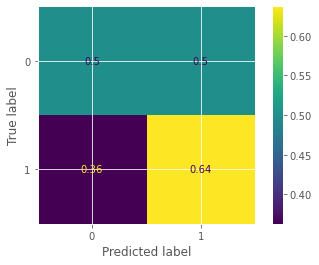

[[147 147]
 [ 70 123]]
              precision    recall  f1-score   support

           0       0.68      0.50      0.58       294
           1       0.46      0.64      0.53       193

    accuracy                           0.55       487
   macro avg       0.57      0.57      0.55       487
weighted avg       0.59      0.55      0.56       487


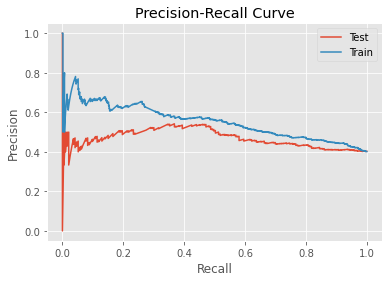

AUPRC Test: 0.47
f1_train: 0.541586 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': True}
f1_test:  0.48847926267281105


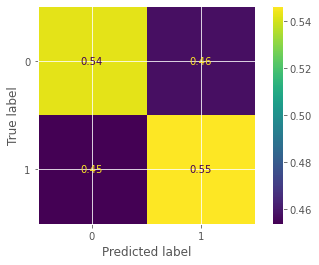

[[159 134]
 [ 88 106]]
              precision    recall  f1-score   support

           0       0.64      0.54      0.59       293
           1       0.44      0.55      0.49       194

    accuracy                           0.54       487
   macro avg       0.54      0.54      0.54       487
weighted avg       0.56      0.54      0.55       487


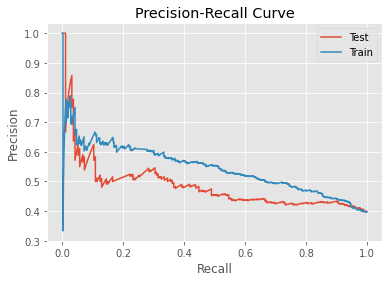

AUPRC Test: 0.48
f1_train: 0.550026 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'linear', 'shrinking': False}
f1_test:  0.5626477541371159


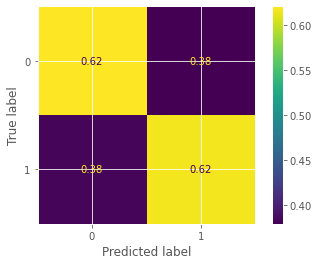

[[182 111]
 [ 74 119]]
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       293
           1       0.52      0.62      0.56       193

    accuracy                           0.62       486
   macro avg       0.61      0.62      0.61       486
weighted avg       0.63      0.62      0.62       486


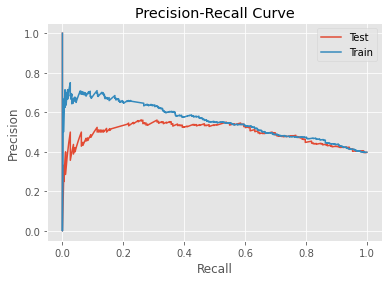

AUPRC Test: 0.49
f1_train: 0.502341 using {'C': 0.5, 'class_weight': 'balanced', 'kernel': 'rbf', 'shrinking': True}
f1_test:  0.5336426914153133


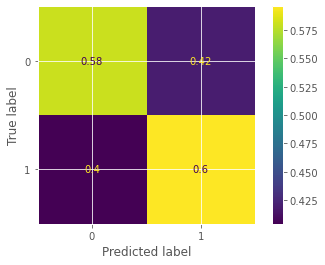

[[170 123]
 [ 78 115]]
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       293
           1       0.48      0.60      0.53       193

    accuracy                           0.59       486
   macro avg       0.58      0.59      0.58       486
weighted avg       0.61      0.59      0.59       486


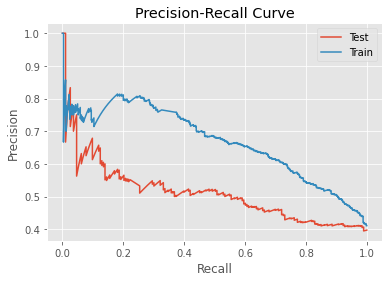

AUPRC Test: 0.51


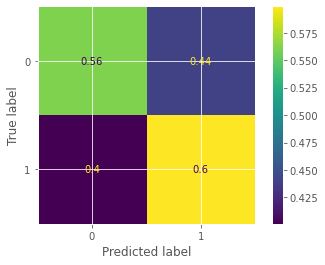

[[658 515]
 [310 463]]
              precision    recall  f1-score   support

           0       0.68      0.56      0.61      1173
           1       0.47      0.60      0.53       773

    accuracy                           0.58      1946
   macro avg       0.58      0.58      0.57      1946
weighted avg       0.60      0.58      0.58      1946


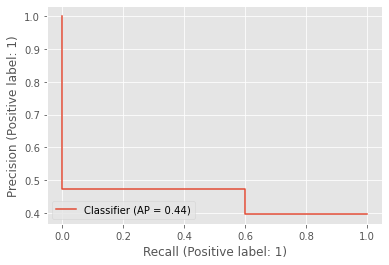

Mean f1 Train: 0.5338821909361064
Mean f1 Test: 0.5290218007064181
Mean AUPRC Test 0.5099060569490209
Mean Precision Test 0.4750876141886746
Mean Recall Test 0.5731310165428837


In [112]:
from sklearn.svm import SVC

model = SVC(probability=True)
parameters={
'kernel': ['linear', 'rbf', 'poly'],
# 'degree': [4, 5,6],
# 'gamma': [0.5,10],
'C': [0.5, 10],
'class_weight': ['balanced'],
'shrinking': [True,False]
}

labels=[]
predictions=[]
f1_sco_train = []
f1_sco=[]
auprc_test = []
prec = []
rec = [] 

# Iterate over the folds
for i in range(len(train_fold)):
    best_model, y_pred, f1_train, f1, auprc, precision, recall = Prediction(model, parameters,  X_train[i], y_train[i], X_test[i], y_test[i])
    f1_sco_train.append(f1_train)
    f1_sco.append(f1)
    labels.append(y_test[i])
    predictions.append(y_pred)
    auprc_test.append(auprc)
    prec.append(precision)
    rec.append(recall)

#  Concatenate the predictions and labels
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

# Compute Mean Scores
f1_mean_train = np.mean(f1_sco_train)
f1_mean=np.mean(f1_sco)
auprc_mean = np.mean(auprc)
prec_mean = np.mean(prec)
rec_mean = np.mean(rec)

plot_confusionMatrix(target, pred)
PrecisionRecallDisplay.from_predictions(target,pred)
plt.show()
print("Mean f1 Train:", f1_mean_train)
print("Mean f1 Test:", f1_mean)
print("Mean AUPRC Test", auprc_mean)
print("Mean Precision Test", prec_mean)
print("Mean Recall Test", rec_mean)

### Logistic Regression

f1_train: 0.532503 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5333333333333332


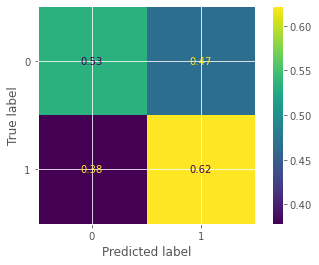

[[157 137]
 [ 73 120]]
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       294
           1       0.47      0.62      0.53       193

    accuracy                           0.57       487
   macro avg       0.57      0.58      0.57       487
weighted avg       0.60      0.57      0.57       487


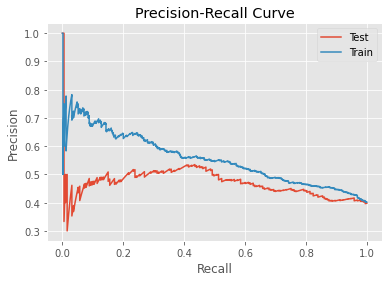

AUPRC Test: 0.47
f1_train: 0.531060 using {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5114155251141552


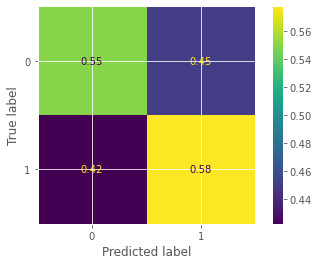

[[161 132]
 [ 82 112]]
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       293
           1       0.46      0.58      0.51       194

    accuracy                           0.56       487
   macro avg       0.56      0.56      0.56       487
weighted avg       0.58      0.56      0.57       487


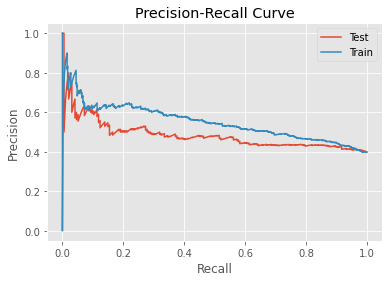

AUPRC Test: 0.48
f1_train: 0.544246 using {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.57002457002457


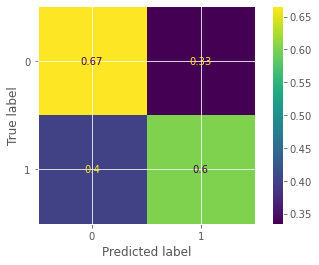

[[195  98]
 [ 77 116]]
              precision    recall  f1-score   support

           0       0.72      0.67      0.69       293
           1       0.54      0.60      0.57       193

    accuracy                           0.64       486
   macro avg       0.63      0.63      0.63       486
weighted avg       0.65      0.64      0.64       486


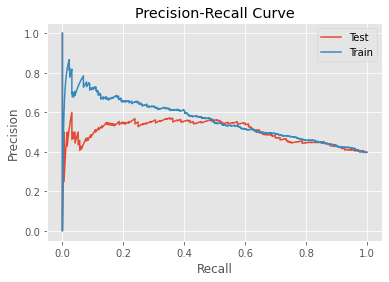

AUPRC Test: 0.50
f1_train: 0.494266 using {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000}
f1_test:  0.5012048192771085


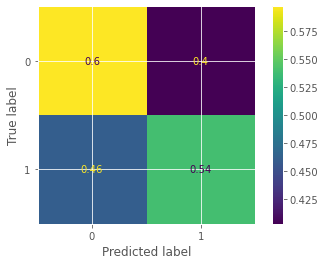

[[175 118]
 [ 89 104]]
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       293
           1       0.47      0.54      0.50       193

    accuracy                           0.57       486
   macro avg       0.57      0.57      0.56       486
weighted avg       0.59      0.57      0.58       486


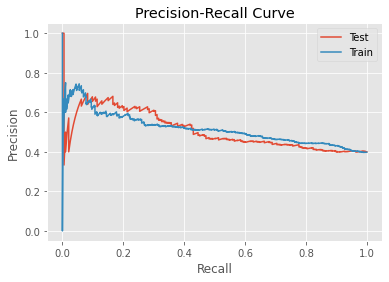

AUPRC Test: 0.51


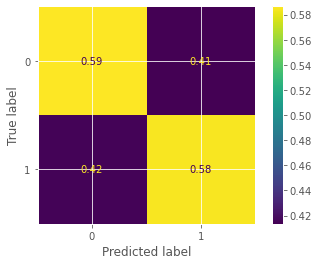

[[688 485]
 [321 452]]
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1173
           1       0.48      0.58      0.53       773

    accuracy                           0.59      1946
   macro avg       0.58      0.59      0.58      1946
weighted avg       0.60      0.59      0.59      1946


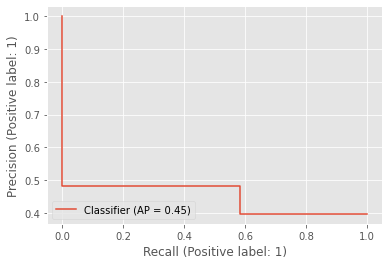

Mean f1 Train: 0.525518659797188
Mean f1 Test: 0.5289945619372917
Mean AUPRC Test 0.5073845304307195
Mean Precision Test 0.47760301639448205
Mean Recall Test 0.562808297714724


In [113]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
parameters = {"C":[1e-4,1e-3,1e-2,1e-1,1,10], "max_iter":[1000],'class_weight': ['balanced'] }

labels=[]
predictions=[]
f1_sco_train = []
f1_sco=[]
auprc_test = []
prec = []
rec = [] 

# Iterate over the folds
for i in range(len(train_fold)):
    best_model, y_pred, f1_train, f1, auprc, precision, recall = Prediction(model, parameters,  X_train[i], y_train[i], X_test[i], y_test[i])
    f1_sco_train.append(f1_train)
    f1_sco.append(f1)
    labels.append(y_test[i])
    predictions.append(y_pred)
    auprc_test.append(auprc)
    prec.append(precision)
    rec.append(recall)

#  Concatenate the predictions and labels
target=np.concatenate(labels, axis=0)
pred = np.concatenate(predictions, axis=0)

#Compute Mean Scores
f1_mean_train = np.mean(f1_sco_train)
f1_mean=np.mean(f1_sco)
auprc_mean = np.mean(auprc)
prec_mean = np.mean(prec)
rec_mean = np.mean(rec)

plot_confusionMatrix(target, pred)
PrecisionRecallDisplay.from_predictions(target,pred)
plt.show()
print("Mean f1 Train:", f1_mean_train)
print("Mean f1 Test:", f1_mean)
print("Mean AUPRC Test", auprc_mean)
print("Mean Precision Test", prec_mean)
print("Mean Recall Test", rec_mean)